# DM Direct detection with DM models (Multi-dimensional study)

> **Project:** Direct Detection and Astrophysics

> **Description:** This file generate constraint and signal contours in the 4D parameter space, the DM-nuclear coupling, DM mass, mediator mass and substructure fraction. We use the Swordfish module to produce and forecast upper limits (equivalent count method) and signal contours (Euclideanized signal method). We investigate the effects of varying astrophysics on DD experiments signal interpretation.

> **Author:** John Shing Chau Leung

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import division    #for division operator
import swordfish as sf
import math, numpy as np
from astropy import constants as const
from astropy import units as u
from astropy import coordinates as coord
from scipy.special import erf, spherical_jn, factorial
from scipy.integrate import quad, odeint, simps, nquad
import scipy.stats as stats
from scipy.interpolate import interp1d, interp2d, InterpolatedUnivariateSpline, griddata
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.transforms import Bbox
import warnings

from time import sleep
from tqdm import tqdm

import h5py
from sklearn import svm
from scipy.linalg import eig, eigvals
from random import randint
from itertools import cycle
import h5py
from sklearn.linear_model import Ridge
from sklearn.neighbors import BallTree
from scipy import interpolate

import swordfish as sf
from scipy.constants import c
from numpy.random import multivariate_normal
from matplotlib import rc
from scipy.interpolate import UnivariateSpline

import sys

sys.path.insert(0, "/Users/john/Desktop/direct_detection/code")

import operators as ops
import astrophys as fv

plt.style.use('seaborn-bright')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100

rhoDM = 0.4
fmtoInverseGeV= 1.0/0.197
AMUtoGeV= 0.93146
mProton= 0.938   #in GeV
mNeutron= 0.9396 #in GeV
GFermi = 1.166E-5     #in GeV^(-2)
keVtoGeV= 1e-6 
invVelToUnitless = 3.0E5
SHM_sig_color = 'darkcyan'
Gaia_sig_color = 'coral'
SHM_excl_style = 'solid'
Gaia_excl_style = 'dashed'
excl_1T_color = 'gold'
excl_Da_color = 'indigo'

/Users/john/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load astrophysics data required to calculate cross-section. Generate the velocity moment functions.

In [2]:
operators = ops.Operator(1,1)

generating default halo


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


generating SHM


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


generating default halo


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


generating SHM


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


generating NLB full substructure


100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


generating NLB full halo


100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Setup the DD detector exposure and acceptance. We use the XENON1T benchmark (1805.12562).

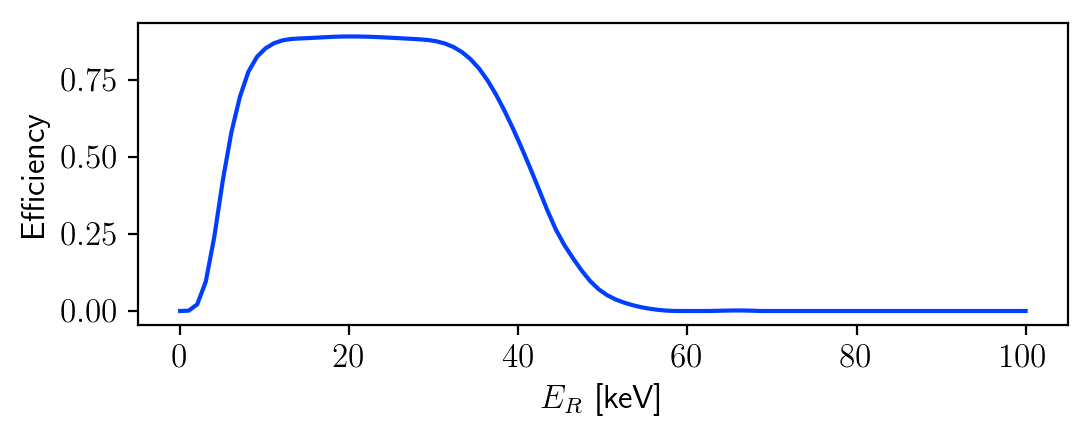

In [3]:
fileDirectory = "contour_data/"
plt.rcParams["figure.figsize"] = (6, 2)

Xe1T_keV, Xe1T_eff = np.loadtxt(fileDirectory+"efficiency_firstdata.csv", unpack=True, usecols=(0,1), skiprows=1, delimiter=',')
Xe1T_eff_curve = interp1d(Xe1T_keV, Xe1T_eff, bounds_error = False, fill_value = (0, 0) , kind='linear')

def exposure_func(experiment): #kg days
    if (experiment =='CDMS'):
        return 1009.8
    if (experiment =='Xenon_1T'):
        return 362440.
    if (experiment =='Xenon_nT'):
        return 365000.*20.
    if (experiment =='Xenon_Darwin'):
        return 365000.*200.
    if (experiment =='Darkside_50'):
        return 365000*0.011
    if (experiment =='Darkside_20k'):
        return 365000*100

def accept_func(ER, experiment):
    #ER in GeV; 
    if (experiment =='CDMS'):
        return (ER < 20.)*(0.32 + 0.007*(ER - 20.))\
            + (ER >= 20.)*(0.25 - (0.07/80.)*(ER - 100.))
    if (experiment =='Xenon_1T'):
        return Xe1T_eff_curve(ER)*0.5
    if (experiment =='Xenon_nT'):
        return Xe1T_eff_curve(ER)*0.5
    if (experiment =='Xenon_Darwin'):
        return Xe1T_eff_curve(ER)*0.5
    if (experiment =='Darkside_50'):
        return np.ones_like(ER)*0.5
    if (experiment =='Darkside_20k'):
        return np.ones_like(ER)*0.5

The recoil function $\frac{\mathrm{d}R_T}{\mathrm{d}E_R}$ in number of events per kilogram year.
> **dRT_DER(ER, mDM, coup, op, med, experiment, acceptance, v_funct)**
>
> **dRT_DER_Model(ER, mDM, coup, op, med, experiment, acceptance, v_funct)**
> - ER: recoil energy in GeV
> - mDM: dark matter mass in GeV
> - coup: coupling constant (g)
> - med: type of interaction (NREFT operators/models)
> - experiment: name of the experment
> - acceptance: Boolean for using acceptance function or not
> - v_funct: name of the DM velocity distribution model

In [4]:
min_mass = 5.0
max_mass = 10**3.5
grid_mass_pts = 100
grid_sigma_pts = 100

def velDM_min(ER, mT, muT):
    return np.sqrt(mT*ER/(2*pow(muT, 2)))*invVelToUnitless

def dRT_dER(ER, mDM, coup, med, experiment, v_funct, acceptance=True):
    #ER and masses in GeV; as a default couplings are set to 1 in appropriate powers of GeV

    if (experiment.split('_')[0] == 'CDMS'):
        target= '72Ge'
    elif (experiment.split('_')[0] == 'Xenon'):
        target= '131Xe'
    elif (experiment.split('_')[0] == 'Darkside'):
        target= '40Ar'
    
    A = operators.A[target]

    ER_GeV = ER*keVtoGeV
    mT, muT= operators.mass_func(mDM, target)
    N_T= 6.05771E8/A #number of scattering centers per 1 kg of target
    v_min= velDM_min(ER_GeV, mT, muT)
    norm_fac = N_T*(mT/(2*np.pi))*pow(coup, 2)*(rhoDM/mDM)
    
    if acceptance == True: 
        accept_f = accept_func(ER, experiment)
    else:
        accept_f = 1.
        
    op_num_div = int(len(med[1:])/2)+1
    op_num_a = int(med[1:op_num_div])
    op_num_b = int(med[op_num_div:])
    
    nuc_form_fac =  operators.F_funct(op_num_a, op_num_b, ER, v_min, mu_T=muT, med=med[0], nu=target, v_funct=v_funct)
    return norm_fac*nuc_form_fac*accept_f

def dRT_dER_Model(ER, mDM, coup, med, experiment, v_funct, acceptance=True):

    if (experiment.split('_')[0] == 'CDMS'):
        target= '72Ge'
    elif (experiment.split('_')[0] == 'Xenon'):
        target= '131Xe'
    elif (experiment.split('_')[0] == 'Darkside'):
        target= '40Ar'
    
    A = operators.A[target]

    ER_GeV = ER*keVtoGeV
    mT, muT= operators.mass_func(mDM, target)
    N_T= 6.05771E8/A #number of scattering centers per 1 kg of target
    v_min= velDM_min(ER_GeV, mT, muT)
    norm_fac = N_T*(mT/(2*np.pi))*pow(coup, 2)*(rhoDM/mDM)
    
    if acceptance == True: 
        accept_f = accept_func(ER, experiment)
    else:
        accept_f = 1.

    #nuc_form_fac =  Model_funct(ER, v_min, mDM, mu_T=muT, med=med, nu=target, v_funct=v_funct)
    nuc_form_fac =  operators.Model_funct(ER, v_min, mDM, mu_T=muT, med=med, nu=target, v_funct=v_funct)
    return norm_fac*nuc_form_fac*accept_f

# Result analysis

We load up the S1 background from 1705.06655 and convert it to $E_R$ space. 

Here we are define the **elc_moment** and **mag_moment** that convert the coupling (g) in unit of GeV to units of electric dipole moment (e cm) and electron Bohr magneton ($\mu_e$).

In [279]:
ER_grid = np.linspace(5.,40.,80)
dER = ER_grid[1] - ER_grid[0]
exposure_2017 = 35636.

s1 = np.linspace(3,70,num=20)
s1width = s1[1]-s1[0]
s1means = s1[0:-1]+s1width/2.
bkgs = ['acc','Anom','ElectronRecoil','n','Neutrino','Wall']


eff1, eff2 = np.loadtxt("./Swordfish_Xenon1T/Efficiency-1705.06655.txt", unpack=True)
efficiency = UnivariateSpline(eff1, eff2, ext="zeros", k=1, s=0)
S1_vals, E_vals = np.loadtxt("./Swordfish_Xenon1T/S1vsER.txt", unpack=True)
CalcER = UnivariateSpline(S1_vals, E_vals, k=5, s=0)
dERdS1 = CalcER.derivative()
CalcS1 = UnivariateSpline(E_vals, S1_vals, k=5, s=0)
dS1dER = CalcER.derivative()

bkg = np.zeros_like(s1means)
for i in range(len(bkgs)):
    S1, temp = np.loadtxt("./DD_files/" + bkgs[i] + ".txt", unpack=True)
    interp = interp1d(S1, temp, bounds_error=False, fill_value=0.0)
    bkg  = bkg + interp(s1means)
bkg_f = interp1d(s1means, bkg, bounds_error=False, fill_value=0.0)
bkg_ER = interp1d(ER_grid, dS1dER(ER_grid)*bkg_f(CalcS1(ER_grid))/exposure_2017)


GeVtoInvcm = 5.06*(10**13); e_charge = np.sqrt(4.*np.pi/137.); e_mass = 511.*(10**(-6))

def elc_moment(g_energy, log_coup = False, log_out = False):
    if log_coup:
        g_energy = 10**g_energy
    if log_out :
        return np.log10(e_charge*g_energy/GeVtoInvcm)
    return 2*e_charge*g_energy/GeVtoInvcm
def mag_moment(g_energy, log_coup = False, log_out = False):
    if log_coup:
        g_energy = 10**g_energy
    if log_out :
        return np.log10(g_energy*2*e_mass/e_charge)
    return g_energy*2*e_mass/e_charge

Define the function to find upper limit with equivalent count method
> **EC_upper_limit(ER, log_mDM_grid, med, experiment, v_funct, alpha = 0.1)**
> - ER: recoil energy grid in keV
> - mDM: grid of log10 of dark matter mass in GeV
> - med: type of interaction (NREFT operators or models)
> - experiment: name of the experment
> - v_funct: name of the DM velocity distribution model
> - alpha: the exclusion level

In [7]:
def EC_upper_limit(ER, log_mDM_grid, med, experiment, v_funct, alpha = 0.1):
    ULlist = []; mass_list_out = []
    dER = ER[1] - ER[0]
    exposure = np.ones_like(ER)*exposure_func(experiment)
    
    warnings.filterwarnings('error')
    
    B_null = np.ones_like(ER)*1e-30
    B_bkg = bkg_ER(ER)
    
    SF = sf.Swordfish([B_bkg+B_null], E=exposure)
    
    low_sigma, high_sigma = operators.get_xsec_lim(med)
    coup_ref = low_sigma
    
    
    for m in log_mDM_grid:
        try:
            if opers[0] != 'h' or opers[0] != 'l':
                dRdE = dRT_dER_Model(ER, 10**m, 10**coup_ref, med, experiment, v_funct, acceptance=True)*dER
            else:
                dRdE = dRT_dER(ER, 10**m, 10**coup_ref, med, experiment, v_funct, acceptance=True)*dER
            limit_pt = SF.upperlimit(dRdE, alpha)
            if limit_pt > 0:
                ULlist.append(limit_pt)
            else:
                continue
            mass_list_out.append(10**m)
        except:
            continue
    ULlist_coup = np.array(np.sqrt(ULlist)*(10**coup_ref))
    
    return ULlist_coup, mass_list_out

Define the signal contour function that uses Euclideanized signal method
> **plot_ellipse(ax, sh, coupling_c0, coupling_c1, cm_plot, contour, ind = None)**
> - ax: matplotlib plot axes
> - sh: Swordfish SignalHandler object
> - coupling_c0: the array for x-axis of the benchmark signal
> - coupling_c1: same for the y-axis
> - cm_plot: the signal point/signal lattice
> - contour: specifies whether it is a SHM or _Gaia_ contour. This decorates the contour to one of the two predetermined colors.
> - ind: if _None_, it takes *cm_plot* as a single point value in the 2D space, which plots a single contour. If it is an integer, it takes *cm_plot* as a contour lattice, and plots the *ind*-th contour in the signal lattice.

In [8]:
def plot_ellipse(ax, sh, coupling_c0, coupling_c1, cm_plot, contour, ind = None):
    min_contour_pts = 4
    P0 = cm_plot
    if ind is not None:
        P0 = cm_plot[ind,:]
    
    if contour == 'SHM':
        color_c = SHM_sig_color
    elif contour == 'NLB':
        color_c = Gaia_sig_color
    pp2, el_ind2, d2 = sh.query_region(P0, sigma=3, d=2, return_distance = True)
    
    z = np.ones_like(coupling_c0[el_ind2])
    x = coupling_c0[el_ind2]
    y = coupling_c1[el_ind2]
    if len(z) < min_contour_pts:
        return
    try:
        ax.tricontour(x, y, d2, colors=[color_c, color_c], levels=[0, 1.5152])
        #ax.tricontourf(x, y, d2, colors=[color_c, color_c], levels=[0, 1.5152], alpha=0.05)
    except:
        return
    return


Define the figure formatting function as a handle for quick matplotlib figure settings.

> **format_fig(ax, x_string, y_string, x_label, y_label, log_log_in = False, log_log_out = False)**
> - ax: matplotlib plot axes
> - x_string: the name of the x-axis object
> - y_string: the name of the y-axis object
> - x_label: x-axis label
> - y_label: y-axis label
> - log_log_in: whether the (x,y) input values have been operated by np.log10
> - log_log_out: whether the (x,y) output values should be operated by np.log10

In [9]:
def format_fig(ax, x_string, y_string, x_label, y_label, log_log_in = False, log_log_out = False):
    
    ax.minorticks_on();
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    ax.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    plt.setp(ax.get_yticklabels()[0], visible=False)
    
    if not log_log_out:
        ax.set_yscale('log')
        ax.set_xscale('log')
    
    xlim_down, xlim_up = ax.get_xlim()
    ylim_down, ylim_up = ax.get_ylim()
    
    def coup_scale(coup):
        if (log_log_in and log_log_out) or (not log_log_in and not log_log_out):
            return coup
        if (not log_log_in and log_log_out):
            return np.log10(coup)
        elif (log_log_in and not log_log_out):
            return 10**coup
    
    yaxsec = ax.twinx();
    xaxsec = ax.twiny();
    
    if not log_log_out:
        yaxsec.set_yscale('log')
        xaxsec.set_xscale('log')
    
    if x_string == 'mass':
        if not log_log_out:
            xaxsec.set_xlabel(r'$m_\chi\ [{\rm GeV}]$', fontsize=18);
        else :
            xaxsec.set_xlabel(r'$\log_{10}(m_\chi)\ [{\rm GeV}]$', fontsize=18);
        xaxsec.set_xlim( coup_scale(xlim_down), coup_scale(xlim_up) );
    elif x_string[:3] == 'mDM':
        xaxsec.set_xlim((  mag_moment(xlim_down, log_log_in, log_log_out), mag_moment(xlim_up, log_log_in, log_log_out) ))
        if x_string[-1] == 'l':
            xaxsec.set_xlabel(r'$\log_{10}(\mu_\chi)\ [\mu_e]$', fontsize=18);
        elif x_string[-1] == 'h':
            xaxsec.set_xlabel(r'$\log_{10}(\mu_\chi)\ [\mu_e{\rm GeV}^{-2}]$', fontsize=18);
    elif x_string[:3] == 'eDM':
        xaxsec.set_xlim( (elc_moment( xlim_down, log_log_in, log_log_out), elc_moment(xlim_up, log_log_in, log_log_out) ))
        if x_string[-1] == 'l':
            xaxsec.set_xlabel(r'$\log_{10}(d_\chi)\ [e\cdot{\rm cm})]$', fontsize=18);
        elif x_string[-1] == 'h':
            xaxsec.set_xlabel(r'$\log_{10}(d_\chi)\ [e\cdot\rm{cm}\cdot\rm{GeV}^{-2}]$', fontsize=18);
    elif x_string[:3] == 'mQ':
        xaxsec.set_xlim((  coup_scale(xlim_down), coup_scale(xlim_up) ))
        xaxsec.set_xlabel(r'$\log_{10}(\epsilon_\chi)$', fontsize=18)
    else:
        xaxsec.set_xlim((coup_scale(xlim_down), coup_scale(xlim_up) ))
        xaxsec.set_xlabel(x_label, fontsize=18);

    xaxsec.minorticks_on();
    xaxsec.tick_params(axis='both', which='major', labelsize=18)
    xaxsec.tick_params(axis='both', which='minor', labelsize=16)
    xaxsec.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    xaxsec.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    plt.setp(xaxsec.get_yticklabels()[0], visible=False)
    ax.xaxis = xaxsec.xaxis
    xaxsec.xaxis.set_label_position('bottom'); xaxsec.xaxis.set_ticks_position('bottom')
    
    if y_string[:3] == 'mDM':
        yaxsec.set_ylim(( mag_moment(ylim_down, log_log_in, log_log_out), mag_moment(ylim_up, log_log_in, log_log_out) ))
        if y_string[-1] == 'l':
            yaxsec.set_ylabel(r'$\log_{10}(\mu_\chi)\ [\mu_e]$', fontsize=18);
        elif y_string[-1] == 'h':
            yaxsec.set_ylabel(r'$\log_{10}(\mu_\chi)\ [\mu_e\cdot{\rm GeV}^{-2}]$', fontsize=18);
    elif y_string[:3] == 'eDM':
        yaxsec.set_ylim(( elc_moment(ylim_down, log_log_in, log_log_out), elc_moment(ylim_up, log_log_in, log_log_out) ))
        if y_string[-1] == 'l':
            yaxsec.set_ylabel(r'$\log_{10}(d_\chi)\ [e\cdot{\rm cm}]$', fontsize=18);
        elif y_string[-1] == 'h':
            yaxsec.set_ylabel(r'$\log_{10}(d_\chi)\ [e\cdot{\rm cm}\cdot{\rm GeV}^{-2}]$', fontsize=18);
    elif y_string[:3] == 'mQ':
        yaxsec.set_ylim((coup_scale(ylim_down), coup_scale(ylim_up) ))
        yaxsec.set_ylabel(r'$\log_{10}(\epsilon_\chi)$', fontsize=18)
    else:
        yaxsec.set_ylim((coup_scale(ylim_down), coup_scale(ylim_up) ))
        yaxsec.set_ylabel(y_label, fontsize=18);
        
    yaxsec.minorticks_on();
    yaxsec.tick_params(axis='both', which='major', labelsize=18)
    yaxsec.tick_params(axis='both', which='minor', labelsize=16)
    yaxsec.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    yaxsec.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    plt.setp(yaxsec.get_yticklabels()[0], visible=False)
    ax.yaxis = yaxsec.yaxis
    yaxsec.yaxis.set_label_position('left'); yaxsec.yaxis.set_ticks_position('left')
    
    return xaxsec, yaxsec

def full_extent(ax, pad=0.0):

    ax.figure.canvas.draw()
    items = [ax, ax.title, ax.xaxis.label, ax.yaxis.label, ax.get_xaxis().get_label(), ax.get_yaxis().get_label()]
    
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

# Mass-coupling upper limit / signal plot

Define the list of models to be examined, in which experiment, the sizing of $E_R$ and DM mass grid, and initialize the S1 background.

Here we define a *B_null* background, which is of extremely small values (such that it is de facto irrelevant). It helps to stablize matrix inversion algorithm for $E_R$ bins that have no S1 background. 

In [479]:
ops_list = ['SS', 'mDM_h', 'mQ','eDM_l']
#ops_list = ['anapole_h','mDM_l']
the_experiment = 'Xenon_Darwin'

ER_grid = np.linspace(5.,40.,80)
dER = ER_grid[1] - ER_grid[0]

event_list = np.zeros_like(ER_grid)
mlist = np.linspace(0.8, 3.5, 200)

exposure = np.ones_like(ER_grid)*exposure_func(the_experiment)
B_null = np.ones_like(ER_grid)*1e-30
B_bkg = bkg_ER(ER_grid)
SF = sf.Swordfish([B_bkg + B_null], E=exposure)

Generate the Euclideanized signals.

In [480]:
couplings_list = [] ; mass_list = [] ; ES_list = []
couplings_NLB_list = [] ; mass_NLB_list = [] ; ES_NLB_list = []
cm_list = []; cm_NLB_list = []
sh_list = []; sh_NLB_list = []

for i_op, opers in enumerate(ops_list):
    low_sigma, high_sigma = operators.get_xsec_lim(opers)
    s10list = np.linspace(low_sigma, high_sigma, 200)
    
    rate = lambda mDM, coup: dRT_dER_Model(ER_grid, mDM, coup, opers, experiment=the_experiment, acceptance=True, v_funct = 'SHM')
    rate_NLB = lambda mDM, coup, eta_sub: eta_sub*dRT_dER_Model(ER_grid, mDM, coup, opers, experiment=the_experiment, acceptance=True, v_funct = 'NLB_subst_full') \
                                    +(1-eta_sub)*dRT_dER_Model(ER_grid, mDM, coup, opers, experiment=the_experiment, acceptance=True, v_funct = 'NLB_halo_full')
    if opers[0] == 'h' or opers[0] == 'l':
        rate = lambda mDM, coup: dRT_dER(ER_grid, mDM, coup, opers, experiment=the_experiment, acceptance=True, v_funct = 'SHM')
        rate_NLB = lambda mDM, coup, eta_sub: eta_sub*dRT_dER(ER_grid, mDM, coup, opers, experiment=the_experiment, acceptance=True, v_funct = 'NLB_subst_full') \
                                    +(1-eta_sub)*dRT_dER_Model(ER_grid, mDM, coup, opers, experiment=the_experiment, acceptance=True, v_funct = 'NLB_halo_full')

    signal = lambda m, c: np.abs(rate(10**m, 10**c)*dER)
    signal_NLB = lambda m, c: np.abs(rate_NLB(10**m, 10**c, 0.42)*dER)

    couplings_temp = []; mass_temp = []; ES_temp = [];
    for m in tqdm(mlist, desc=("Euclideanizing " + opers) ):
        for j, c in enumerate(s10list):
            couplings_temp.append(c)
            mass_temp.append(m)
            dRdER = signal(m, c)
            if np.sum(dRdER)==0:
                continue
            ES_temp.append(SF.euclideanizedsignal(dRdER))

    couplings_list.append( np.array(couplings_temp) )
    mass_list.append( np.array(mass_temp) )
    ES_list.append( np.array(ES_temp) )

    cm = np.zeros([ np.array(couplings_temp).shape[0], 1+1])
    cm[:,0] = np.array( mass_temp )
    cm[:,1] = np.array( couplings_temp )
    
    cm_list.append( cm )
    sh_list.append( sf.SignalHandler( cm, np.array(ES_temp) ) )
    
    couplings_temp = []; mass_temp = []; ES_temp = [];
    for m in tqdm(mlist, desc=("Euclideanizing " + opers) ):
        for j, c in enumerate(s10list):
            couplings_temp.append(c)
            mass_temp.append(m)
            dRdER = signal_NLB(m, c)
            if np.sum(dRdER)==0:
                continue
            ES_temp.append(SF.euclideanizedsignal(dRdER))

    couplings_NLB_list.append( np.array(couplings_temp) )
    mass_NLB_list.append( np.array(mass_temp) )
    ES_NLB_list.append( np.array(ES_temp) )

    cm = np.zeros([np.array(couplings_temp).shape[0], 1+1])
    cm[:,0] = np.array( mass_temp )
    cm[:,1] = np.array( couplings_temp )

    cm_NLB_list.append( cm )
    sh_NLB_list.append( sf.SignalHandler(cm, np.array(ES_temp) ) )

Euclideanizing eDM_l: 100%|██████████| 200/200 [09:06<00:00,  2.73s/it]


### Mass-coupling result plots

We plot the two signal benchmark points for four DM models in mass-coupling plane. We shows both the _Gaia_ and SHM contours, as well as the constraints for references.

The solid lines represent the rate under _Gaia_ astrophysics and the solid lines under SHM. Yellow lines are the XENON1T upper limits with 1 ton year exposure, purple are the projected DARWIN upper limits with 200 ton year exposure. The orange and cyan are the signal contours for _Gaia_ and SHM respectively.

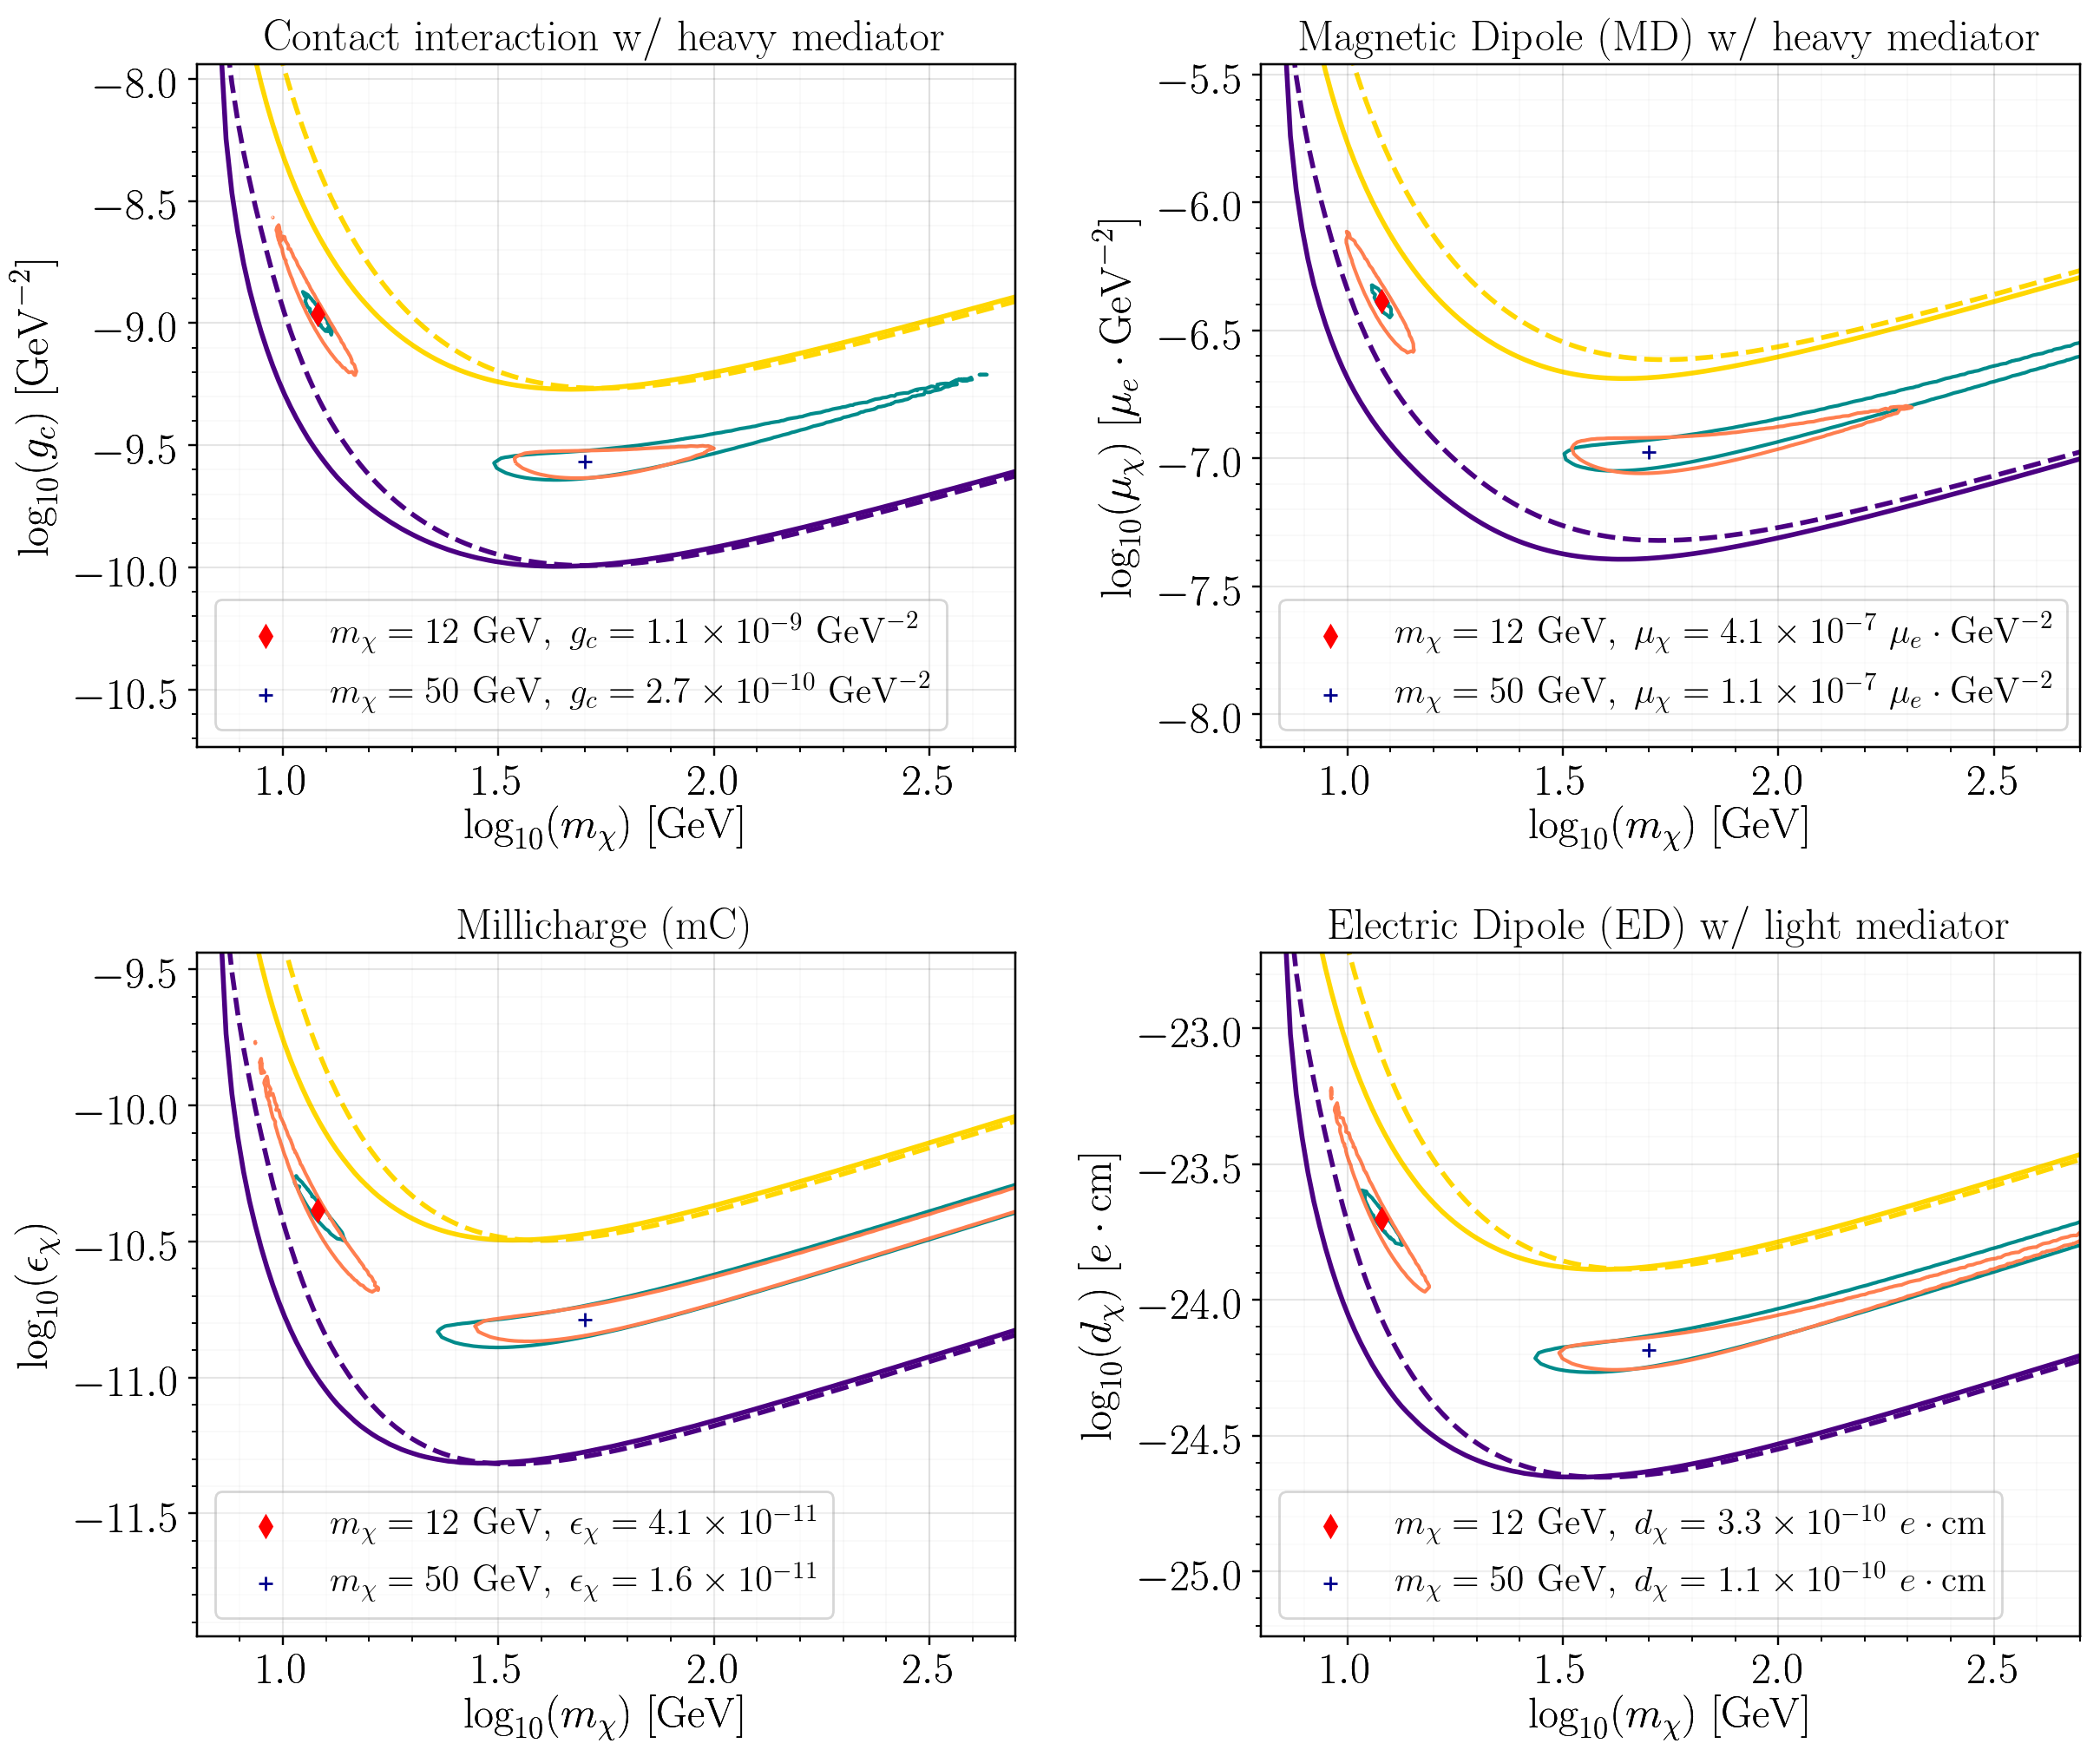

In [487]:
marker_list = ['d','+']; color_list = ['red','darkblue']
coupling_names = [r'g_c', r'\mu_\chi', r'\epsilon_\chi', r'd_\chi']
#coupling_names = [r'g_{{\rm ana}}', r'\mu_\chi']
units = [r'{\rm GeV}^{-2}', r'\mu_e\cdot{\rm GeV}^{-2}', r'\ ', r'e\cdot{\rm cm}']
#units = [r'{\rm GeV}^{-2}', r'\mu_e']
name_list = [r'${\rm Contact\ interaction\ w/\ heavy\ mediator}$', r'${\rm Magnetic\ Dipole\ (MD)\ w/\ heavy\ mediator}$', \
            r'${\rm Millicharge\ (mC)}$', r'${\rm Electric\ Dipole\ (ED)\ w/\ light\ mediator}$']
#name_list = [r'${\rm Anapole\ w/\ heavy\ mediator}$', r'${\rm Magnetic\ Dipole\ (MD)\ w/\ light\ mediator}$']

plt.rcParams["figure.figsize"] = (14, 3.*len(ops_list))
fig, ax = plt.subplots( int(np.ceil(len(ops_list)/2.)) , 2)

fig.subplots_adjust(wspace=0.3, hspace=0.3)


def get_signal_points(sig_list_1, sig_list_2, mask=None):
    pt_1 = [sig_list_1[0], sig_list_2[0]]
    pt_2 = [sig_list_1[1], sig_list_2[1]]
    signal_pts = np.array([pt_1, pt_2])
    if mask is not None:
        return signal_pts[mask]
    return signal_pts

mass_pt = [1.08, 1.7]

SS_list = [-8.962, -9.568];
mu_h_list = [-3.914, -4.502];
mQ_list = [-10.384, -10.789];
de_l_list = [-9.478, -9.962];
ana_h_list = [-5.010, -5.682];
mu_l_list = [-6.735, -7.011]

cm_plot_list = [ get_signal_points(mass_pt, SS_list), \
                 get_signal_points(mass_pt, mu_h_list), \
                 get_signal_points(mass_pt, mQ_list), \
                 get_signal_points(mass_pt, de_l_list) ]

xaxsec_list = []; yaxsec_list = []

for i_op, opers in enumerate(ops_list):
    row_indx = np.divide(i_op, 2);
    col_indx = np.mod(i_op, 2)
    
    cm_plot = cm_plot_list[i_op]
    sh = sh_list[i_op]; sh_NLB = sh_NLB_list[i_op]
    mass = mass_list[i_op]; mass_NLB = mass_NLB_list[i_op]
    couplings = couplings_list[i_op] ; couplings_NLB = couplings_NLB_list[i_op]
       
    for j_p, P0 in enumerate(cm_plot):
        if opers[:3] == 'eDM':
            cal_coup = elc_moment(P0[1], log_coup = True, log_out = True)
        if opers[:3] == 'mDM':
            cal_coup = mag_moment(P0[1], log_coup = True, log_out = True)
        else:
            cal_coup = P0[1]
        pow_coup = int(cal_coup-1); dig_coup = (cal_coup - pow_coup)
        pt_desc = r'$m_\chi = %i \ {\rm GeV},\ %s = %.1f \times 10^{%i} \ %s $'% (int(10**P0[0]), coupling_names[i_op], 10**dig_coup, pow_coup, units[i_op])
        ax[row_indx, col_indx].plot(P0[0], P0[1], marker=marker_list[j_p], color=color_list[j_p], linestyle = 'None', label=pt_desc)
        plot_ellipse(ax[row_indx, col_indx], sh, mass, couplings, P0, 'SHM')
        plot_ellipse(ax[row_indx, col_indx], sh_NLB, mass_NLB, couplings_NLB, P0, 'NLB')
        
    log_mass_list = np.linspace(min(mlist), max(mlist), 300)
    plot_contours, plot_mass = EC_upper_limit(ER_grid, mlist, opers, 'Xenon_1T', 'SHM')
    ax[row_indx, col_indx].plot(np.log10(plot_mass), np.log10(plot_contours), color=excl_1T_color, linestyle=SHM_excl_style, linewidth=2)
    plot_contours, plot_mass = EC_upper_limit(ER_grid, mlist, opers, 'Xenon_Darwin', 'NLB_full')
    ax[row_indx, col_indx].plot(np.log10(plot_mass), np.log10(plot_contours), color=excl_Da_color, linestyle=Gaia_excl_style, linewidth=2)
    plot_contours, plot_mass = EC_upper_limit(ER_grid, mlist, opers, 'Xenon_Darwin', 'SHM')
    ax[row_indx, col_indx].plot(np.log10(plot_mass), np.log10(plot_contours), color=excl_Da_color, linestyle=SHM_excl_style, linewidth=2)
    plot_contours, plot_mass = EC_upper_limit(ER_grid, mlist, opers, 'Xenon_1T', 'NLB_full')
    ax[row_indx, col_indx].plot(np.log10(plot_mass), np.log10(plot_contours), color=excl_1T_color, linestyle=Gaia_excl_style, linewidth=2)
    
    
    ax[row_indx, col_indx].legend(loc='lower left', frameon=True, fontsize=15)
    xlim_d, xlim_u = ax[row_indx, col_indx].get_xlim(); ax[row_indx, col_indx].set_xlim((0.8, 2.7))
    if col_indx == 0 and row_indx == 0:
        ylim_d, ylim_u = ax[row_indx, col_indx].get_ylim(); ax[row_indx, col_indx].set_ylim((ylim_d-0.5, ylim_u-3.))
    elif  col_indx == 0 and row_indx == 1:
        ylim_d, ylim_u = ax[row_indx, col_indx].get_ylim(); ax[row_indx, col_indx].set_ylim((ylim_d-0.4, ylim_u-3.))
    elif  col_indx == 1 and row_indx == 0:
        ylim_d, ylim_u = ax[row_indx, col_indx].get_ylim(); ax[row_indx, col_indx].set_ylim((ylim_d-0.5, ylim_u-3.))
    else:
        ylim_d, ylim_u = ax[row_indx, col_indx].get_ylim(); ax[row_indx, col_indx].set_ylim((ylim_d-0.35, ylim_u-3.))
    format_fig(ax[row_indx, col_indx], 'mass', opers, None, r'$\log_{10}(g_{c})\ [\rm{GeV}^{-2}]$', log_log_in = True, log_log_out = True)
    ax[row_indx, col_indx].set_title(name_list[i_op], fontsize=18)

fig.savefig('signal_all.pdf', bbox_inches = 'tight')
plt.show()

Calculate the total numbers of event. We compare signals across benchmark points that have the **same** numbers of events.

In [489]:
for i_op, opers in enumerate(ops_list):
    cm_plot = cm_plot_list[i_op]
    for cm in cm_plot:
        mass = 10**cm[0]; coup = 10**cm[1]
        print ("No. of events for %s , mass %d, coup, %.1E:" % (opers, mass, coup))
        print np.sum(exposure_func('Xenon_Darwin')*dRT_dER_Model(ER_grid, mass, coup, opers, experiment='Xenon_Darwin', acceptance=False, v_funct = 'SHM')*dER)

No. of events for SS , mass 12, coup, 1.1E-09:
351.81441459913424
No. of events for SS , mass 50, coup, 2.7E-10:
351.39980909063075
No. of events for mDM_h , mass 12, coup, 1.2E-04:
350.46189420684266
No. of events for mDM_h , mass 50, coup, 3.1E-05:
351.1487050224582
No. of events for mQ , mass 12, coup, 4.1E-11:
351.5978441631791
No. of events for mQ , mass 50, coup, 1.6E-11:
351.8016041218923
No. of events for eDM_l , mass 12, coup, 3.3E-10:
350.89839036628246
No. of events for eDM_l , mass 50, coup, 1.1E-10:
350.82751294891114


# Model-Model signals

In this section, we hold DM mass fixed and examine the ability of a future DD experiment to constraint models given a DM signal. We compare models pairwise, and assume the underlying signals either 1.) belongs to one of the two models; 2.) a combination of two models with comparable coupling coefficients.

First, we examine the recoil spectra. The left column of plots represents the recoil spectra under SHM and the right column represents that under _Gaia_. The different colored curves are the different models. The translucent bands are the $\pm\sqrt{N}$ poisson statistical uncertainties associated with the recoil spectra.

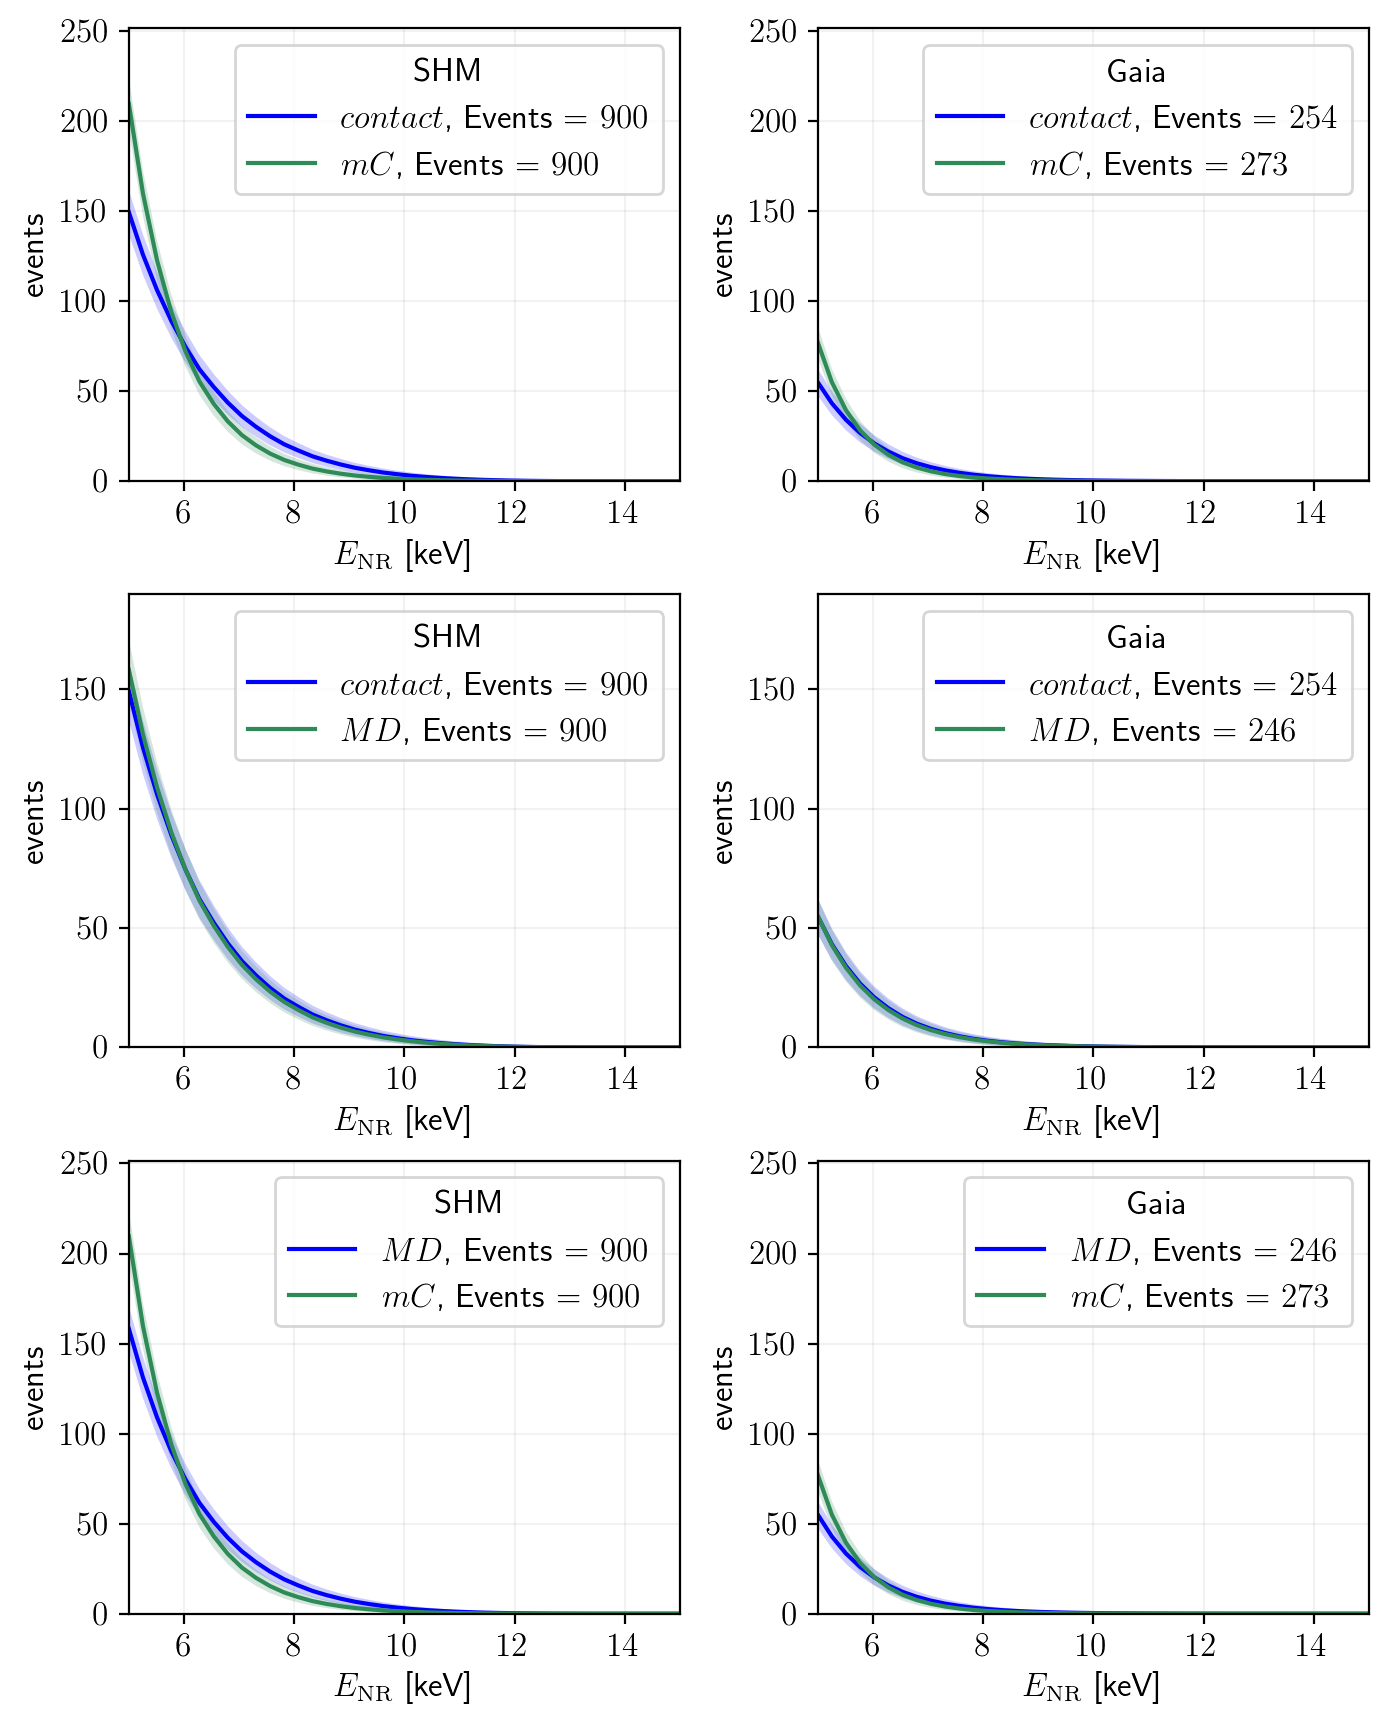

In [343]:
m_point = 12.

ops_pair_list = [['SS','mQ'], ['SS','mDM_l'], ['mDM_l','mQ']]

expos = exposure_func('Xenon_Darwin')

oper_names = [['contact', 'mC'], ['contact', 'MD'], ['MD', 'mC']]


L_SS_list = [-8.7415-1.7, -8.7415]; H_SS_list = [-9.695-1.3, -9.695]; HH_SS_list = [-10.-1.5, -10.]
L_mQ_list = [-10.1576-1.7, -10.1576 ]; H_mQ_list = [-10.929-1.4, -10.929]; HH_mQ_list = [-11.3-1., -11.3]
L_mu_h_list = [-3.87-1.6, -3.87]; H_mu_h_list = [-4.8-1.4, -4.8]; HH_mu_h_list = [-4.9-1., -4.9]
L_de_h_list = [-6.3-1.7, -6.3]; H_de_h_list = [-7.7-1.5, -7.7]; HH_de_h_list = [-7.5-1.5, -7.5]
L_ana_h_list = [-4.5-1.6, -4.4]; H_ana_h_list = [-5.9-2.2, -5.9]; HH_ana_h_list = [-5.9, -5.9]
L_mu_l_list = [-6.5134-2.5, -6.5134]; H_mu_l_list = [-7.143-2.0, -7.143]; HH_mu_l_list = [ -7.5-2.,  -7.55]

def get_signal_points(sig_list_1, sig_list_2, mask=None):
    pt_1 = [sig_list_1[1], sig_list_2[0]]
    pt_2 = [sig_list_1[1], sig_list_2[1]]
    pt_3 = [sig_list_1[0], sig_list_2[1]]
    signal_pts = np.array([pt_1, pt_2, pt_3])
    if mask is not None:
        return signal_pts[np.array(mask, dtype=bool)]
    return signal_pts


if m_point < 20.:
    muH_mQ_list = get_signal_points(L_mu_h_list, L_mQ_list, [1,0,1])
    SS_mQ_list = get_signal_points(L_SS_list, L_mQ_list, [1,0,1])
    SS_muH_list = get_signal_points(L_SS_list, L_mu_h_list, [1,0,1])
    SS_muL_list = get_signal_points(L_SS_list, L_mu_l_list, [1,0,1])
    muL_mQ_list = get_signal_points(L_mu_l_list, L_mQ_list, [1,0,1])
    muL_muH_list = get_signal_points(L_mu_l_list, L_mu_h_list, [1,0,1])
    ER_grid = np.linspace(5., 15., 40)
elif m_point < 79.:
    muH_mQ_list = get_signal_points(H_mu_h_list, H_mQ_list, [1,0,1])
    SS_mQ_list = get_signal_points(H_SS_list, H_mQ_list, [1,0,1])
    SS_muH_list = get_signal_points(H_SS_list, H_mu_h_list, [1,0,1])
    SS_muL_list = get_signal_points(H_SS_list, H_mu_l_list, [1,0,1])
    muL_mQ_list = get_signal_points(H_mu_l_list, H_mQ_list, [1,0,1])
    muL_muH_list = get_signal_points(H_mu_l_list, H_mu_h_list, [1,0,1])
    ER_grid = np.linspace(5., 40., 40)
    
dER = ER_grid[1]-ER_grid[0]

list_coup = [SS_mQ_list, SS_muL_list, muL_mQ_list]

colorings = ['blue', 'seagreen', 'red']

plt.rcParams["figure.figsize"] = (8, 3.5*len(ops_pair_list))
fig, ax = plt.subplots( int(np.ceil(len(ops_pair_list))) , 2)
fig.subplots_adjust(wspace=0.25,hspace=0.25)

for i_op, opers in enumerate(ops_pair_list):
    oper_name = oper_names[i_op]
    
    for j_coup, coups in enumerate(list_coup[i_op]):
        
        opers_shm = expos*dER*(dRT_dER_Model(ER_grid, m_point, 10**(coups[0]), opers[0], experiment=the_experiment, acceptance=False, v_funct = 'SHM')  \
                    + dRT_dER_Model(ER_grid, m_point, 10**(coups[1]), opers[1], experiment=the_experiment, acceptance=False, v_funct = 'SHM') )
        opers_gaia = expos*dER*(dRT_dER_Model(ER_grid, m_point, 10**(coups[0]), opers[0], experiment=the_experiment, acceptance=False, v_funct = 'NLB_full') \
                                    +dRT_dER_Model(ER_grid, m_point, 10**(coups[1]), opers[1], experiment=the_experiment, acceptance=False, v_funct = 'NLB_full'))

        events_SHM = np.sum(opers_shm)
        events_Gaia = np.sum(opers_gaia)
        
        if j_coup == 0:
            label_shm = '{0}, Events = {1}'.format(oper_name[0], int(events_SHM))
            label_gaia = '{0}, Events = {1}'.format(oper_name[0], int(events_Gaia))
        elif j_coup == 2:
            label_shm = '{0} + {1}, Events = {2}'.format(oper_name[0], oper_name[1], int(events_SHM))
            label_gaia = '{0} + {1}, Events = {2}'.format(oper_name[0], oper_name[1], int(events_Gaia))
        elif j_coup == 1:
            label_shm = '{0}, Events = {1}'.format(oper_name[1], int(events_SHM))
            label_gaia = '{0}, Events = {1}'.format(oper_name[1], int(events_Gaia))
        
        SHM_fig = ax[i_op, 0].plot(ER_grid, opers_shm, color=colorings[j_coup], label= label_shm)
        Gaia_fig = ax[i_op, 1].plot(ER_grid, opers_gaia, color=colorings[j_coup], label=label_gaia )
        
        y_shm_p = (opers_shm + np.sqrt(opers_shm))
        y_shm_n = (opers_shm - np.sqrt(opers_shm))
        y_gaia_p = (opers_gaia + np.sqrt(opers_gaia))
        y_gaia_n = (opers_gaia - np.sqrt(opers_gaia))
        ax[i_op, 0].fill_between(ER_grid, y_shm_p, y_shm_n, where=(y_shm_n <= y_shm_p), facecolor=colorings[j_coup], interpolate=True, alpha=0.2)
        ax[i_op, 1].fill_between(ER_grid, y_gaia_p, y_gaia_n, where=(y_gaia_n <= y_gaia_p), facecolor=colorings[j_coup], interpolate=True, alpha=0.2)
    
    ax[i_op, 0].legend(title='SHM'); ax[i_op, 1].legend(title='Gaia')
    ax[i_op, 0].set_xlim(5,max(ER_grid)); ax[i_op, 1].set_xlim(5,max(ER_grid))
    ax[i_op, 0].set_xlabel(r'$E_{\rm NR}$ [keV]'); ax[i_op, 1].set_xlabel(r'$E_{\rm NR}$ [keV]')
    ax[i_op, 0].set_ylabel("events"); ax[i_op, 0].set_ylim( (0, 1.2*max(np.append(opers_shm, opers_gaia)  )) )
    ax[i_op, 1].set_ylabel("events"); ax[i_op, 1].set_ylim( (0, 1.2*max(np.append(opers_shm, opers_gaia)  )) )
    ax[i_op, 0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    ax[i_op, 1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    ax[i_op, 0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    ax[i_op, 1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')

Generate the signal contours in the coupling-coupling plane.

In [336]:
ops_pair_list = [['SS','mQ'], ['mDM_l','mQ']]
the_experiment = 'Xenon_Darwin'

ER_grid = np.linspace(5.,40.,80)
exposure = np.ones_like(ER_grid)*exposure_func(the_experiment)
B_null = np.ones_like(ER_grid)*1e-30
B_bkg = bkg_ER(ER_grid)
SF = sf.Swordfish([B_bkg + B_null], E=exposure)

coupling_c0_list = []; coupling_c1_list = [];
coupling_NLB_c0_list = []; coupling_NLB_c1_list = [];
cc_list = []; cc_NLB_list = []; sh1_list = []; sh1_NLB_list = []

for i_op, opers in enumerate(ops_pair_list):
    low_sigma_0, high_sigma_0 = operators.get_xsec_lim(opers[0])
    low_sigma_1, high_sigma_1 = operators.get_xsec_lim(opers[1])
    low_sigma_0 = low_sigma_0-0.5   ; high_sigma_0 = high_sigma_0
    low_sigma_1 = low_sigma_1-0.5  ; high_sigma_1 = high_sigma_1
    sh0list = np.linspace(low_sigma_0, high_sigma_0, 200)
    sh1list = np.linspace(low_sigma_1, high_sigma_1, 200)

    #sh1list = np.logspace(-8,-10,200)#interp_C0_grid_SHM_Xe[0][2]
    #sh2list = np.logspace(-2,-6,200)#interp_C0_grid_SHM_Xe[0][2]*(10**5.)

    event_list = np.zeros_like(ER_grid)

    rate_h0 = lambda mDM, coup: dRT_dER_Model(ER_grid, mDM, 10**coup, opers[0], experiment=the_experiment, acceptance=True, v_funct = 'SHM')
    rate_h1 = lambda mDM, coup: dRT_dER_Model(ER_grid, mDM, 10**coup, opers[1], experiment=the_experiment, acceptance=True, v_funct = 'SHM')
    signal = lambda c0, c1: ( rate_h0(m_point, c0) + rate_h1(m_point, c1) )*dER
    rate_NLB_h0 = lambda mDM, coup, eta_sub: eta_sub*dRT_dER_Model(ER_grid, mDM, 10**coup, opers[0], experiment=the_experiment, acceptance=True, v_funct = 'NLB_subst_full') \
                                    +(1-eta_sub)*dRT_dER_Model(ER_grid, mDM, 10**coup, opers[0], experiment=the_experiment, acceptance=True, v_funct = 'NLB_halo_full')
    rate_NLB_h1 = lambda mDM, coup, eta_sub: eta_sub*dRT_dER_Model(ER_grid, mDM, 10**coup, opers[1], experiment=the_experiment, acceptance=True, v_funct = 'NLB_subst_full') \
                                    +(1-eta_sub)*dRT_dER_Model(ER_grid, mDM, 10**coup, opers[1], experiment=the_experiment, acceptance=True, v_funct = 'NLB_halo_full')
    signal_NLB = lambda c0, c1: ( rate_NLB_h0(m_point, c0, 0.42) + rate_NLB_h1(m_point, c1, 0.42) )*dER

    xx, yy = np.meshgrid(ER_grid, ER_grid)
    kk = np.zeros_like(xx)


    c0s_temp = []; c1s_temp = []; ES_temp = [];
    for c0 in tqdm(sh0list, desc=("Euclideanizing SHM "+ str(opers) )):
        for c1 in sh1list:
            c0s_temp.append(c0)
            c1s_temp.append(c1)
            dRdER = signal(c0, c1)
            if np.sum(dRdER)==0:
                continue
            ES_temp.append(SF.euclideanizedsignal(dRdER))

    coupling_c0_list.append( np.array(c0s_temp) )
    coupling_c1_list.append( np.array(c1s_temp) )
    
    cc = np.zeros([ np.array(c1s_temp).shape[0], 1+1])
    cc[:,0] = np.array( c0s_temp )
    cc[:,1] = np.array( c1s_temp )
    
    cc_list.append( cc )
    sh1_list.append( sf.SignalHandler( cc, np.array(ES_temp) ) )

    c0s_temp = []; c1s_temp = []; ES_temp = [];
    for c0 in tqdm(sh0list, desc=("Euclideanizing Gaia "+ str(opers) )):
        for c1 in sh1list:
            c0s_temp.append(c0)
            c1s_temp.append(c1)
            dRdER = signal_NLB(c0, c1)
            if np.sum(dRdER)==0:
                continue
            ES_temp.append(SF.euclideanizedsignal(dRdER))

    coupling_NLB_c0_list.append( np.array(c0s_temp) )
    coupling_NLB_c1_list.append( np.array(c1s_temp) )
    
    cc = np.zeros([ np.array(c1s_temp).shape[0], 1+1])
    cc[:,0] = np.array( c0s_temp )
    cc[:,1] = np.array( c1s_temp )
    
    cc_NLB_list.append( cc )
    sh1_NLB_list.append( sf.SignalHandler( cc, np.array(ES_temp) ) )

Euclideanizing Gaia ['mDM_l', 'mQ']: 100%|██████████| 200/200 [11:17<00:00,  3.39s/it]


Generate the upper limit of XENON1T and the projected upper limit of Darwin in the coupling-coupling plane. These curves serve as the visual reference of the coupling strengths.

In [339]:
ops_pair_list = [['SS','mQ'], ['mDM_l','mQ']]

model_NLB_plot_list = []
model_NLB_Da_plot_list = []
model_SHM_plot_list = []
model_SHM_Da_plot_list = []

alpha_2ndf = 0.05; max_alpha = 0.5; min_alpha = alpha_2ndf/max_alpha
param_range_max_asympt = np.linspace(-2, -8, 100)
param_range_linear = np.linspace(min_alpha+0.02, max_alpha-0.02, 100)
param_range_min_asympt = np.linspace(-8, -2, 100)

param_range = np.hstack( ((10**param_range_min_asympt + min_alpha), param_range_linear, (max_alpha - 10**param_range_max_asympt)) )

for i_op, opers in enumerate(ops_pair_list):

    model_NLB_plot_vec_x = []; model_NLB_plot_vec_y = []
    model_NLB_Da_plot_vec_x = []; model_NLB_Da_plot_vec_y = [];
    model_SHM_plot_vec_x = []; model_SHM_plot_vec_y = []
    model_SHM_Da_plot_vec_x = []; model_SHM_Da_plot_vec_y = []
    
    for param_j in tqdm(param_range, desc=("Drawing contours " + str(opers))):
        op_x = opers[0]; op_y = opers[1]
        the_alpha = param_j; compl_alpha = alpha_2ndf/param_j
        
        SHM_Da_x_pt, plot_log_mass = EC_upper_limit(ER_grid, np.log10([m_point]), op_x, 'Xenon_Darwin', 'SHM', the_alpha)
        SHM_Da_y_pt, plot_log_mass = EC_upper_limit(ER_grid, np.log10([m_point]), op_y, 'Xenon_Darwin', 'SHM', compl_alpha)
        if (len(SHM_Da_x_pt) > 0) and (len(SHM_Da_y_pt) > 0):
            model_SHM_Da_plot_vec_x.append(SHM_Da_x_pt[0]) ;  model_SHM_Da_plot_vec_y.append(SHM_Da_y_pt[0])
            
        SHM_x_pt, plot_log_mass = EC_upper_limit(ER_grid, np.log10([m_point]), op_x, 'Xenon_1T', 'SHM', the_alpha)
        SHM_y_pt, plot_log_mass = EC_upper_limit(ER_grid, np.log10([m_point]), op_y, 'Xenon_1T', 'SHM', compl_alpha)
        if (len(SHM_x_pt) > 0) and (len(SHM_y_pt) > 0):
            model_SHM_plot_vec_x.append(SHM_x_pt[0]) ;  model_SHM_plot_vec_y.append(SHM_y_pt[0])
            
        NLB_Da_x_pt, plot_log_mass = EC_upper_limit(ER_grid, np.log10([m_point]), op_x, 'Xenon_Darwin', 'NLB_full', the_alpha)
        NLB_Da_y_pt, plot_log_mass = EC_upper_limit(ER_grid, np.log10([m_point]), op_y, 'Xenon_Darwin', 'NLB_full', compl_alpha)
        if (len(NLB_Da_x_pt) > 0) and (len(NLB_Da_y_pt) > 0):
            model_NLB_Da_plot_vec_x.append(NLB_Da_x_pt[0]) ;  model_NLB_Da_plot_vec_y.append(NLB_Da_y_pt[0])
            
        NLB_x_pt, plot_log_mass = EC_upper_limit(ER_grid, np.log10([m_point]), op_x, 'Xenon_1T', 'NLB_full', the_alpha)
        NLB_y_pt, plot_log_mass = EC_upper_limit(ER_grid, np.log10([m_point]), op_y, 'Xenon_1T', 'NLB_full', compl_alpha)
        if (len(NLB_x_pt) > 0) and (len(NLB_y_pt) > 0):
            model_NLB_plot_vec_x.append(NLB_x_pt[0]) ;  model_NLB_plot_vec_y.append(NLB_y_pt[0])
        
    model_NLB_plot_list.append( [model_NLB_plot_vec_x, model_NLB_plot_vec_y] )
    model_NLB_Da_plot_list.append( [model_NLB_Da_plot_vec_x, model_NLB_Da_plot_vec_y] )
    model_SHM_plot_list.append( [model_SHM_plot_vec_x, model_SHM_plot_vec_y] )
    model_SHM_Da_plot_list.append( [model_SHM_Da_plot_vec_x, model_NLB_Da_plot_vec_y] )

Drawing contours ['mDM_l', 'mQ']: 100%|██████████| 300/300 [00:37<00:00,  7.97it/s]


### Coupling-coupling signal plots

Here we demonstrate two models alongside with their recoil spectra. The first model is the millicharged DM (mC). We compare it against the contact interaction to see if DARWIN can distinguish the correct model from the simplist contact interaction assumption. The second we present a model of millicharged DM with similar sizes of couplings through the fractional electric charge and the anomalous magnetic dipole moment (MD).

The left two columns show the recoil spectra. The rightmost column is the result contour. The dashed curves are the _Gaia_ upper limit and the solid are the SHM upper limit. The yellow curves are the XENON1T upper limit and the purple are the DARWIN projected upper limits. The orange are the _Gaia_ signal coutours and the cyan are the SHM signal contours. The convention here follows that of the mass-coupling plot.

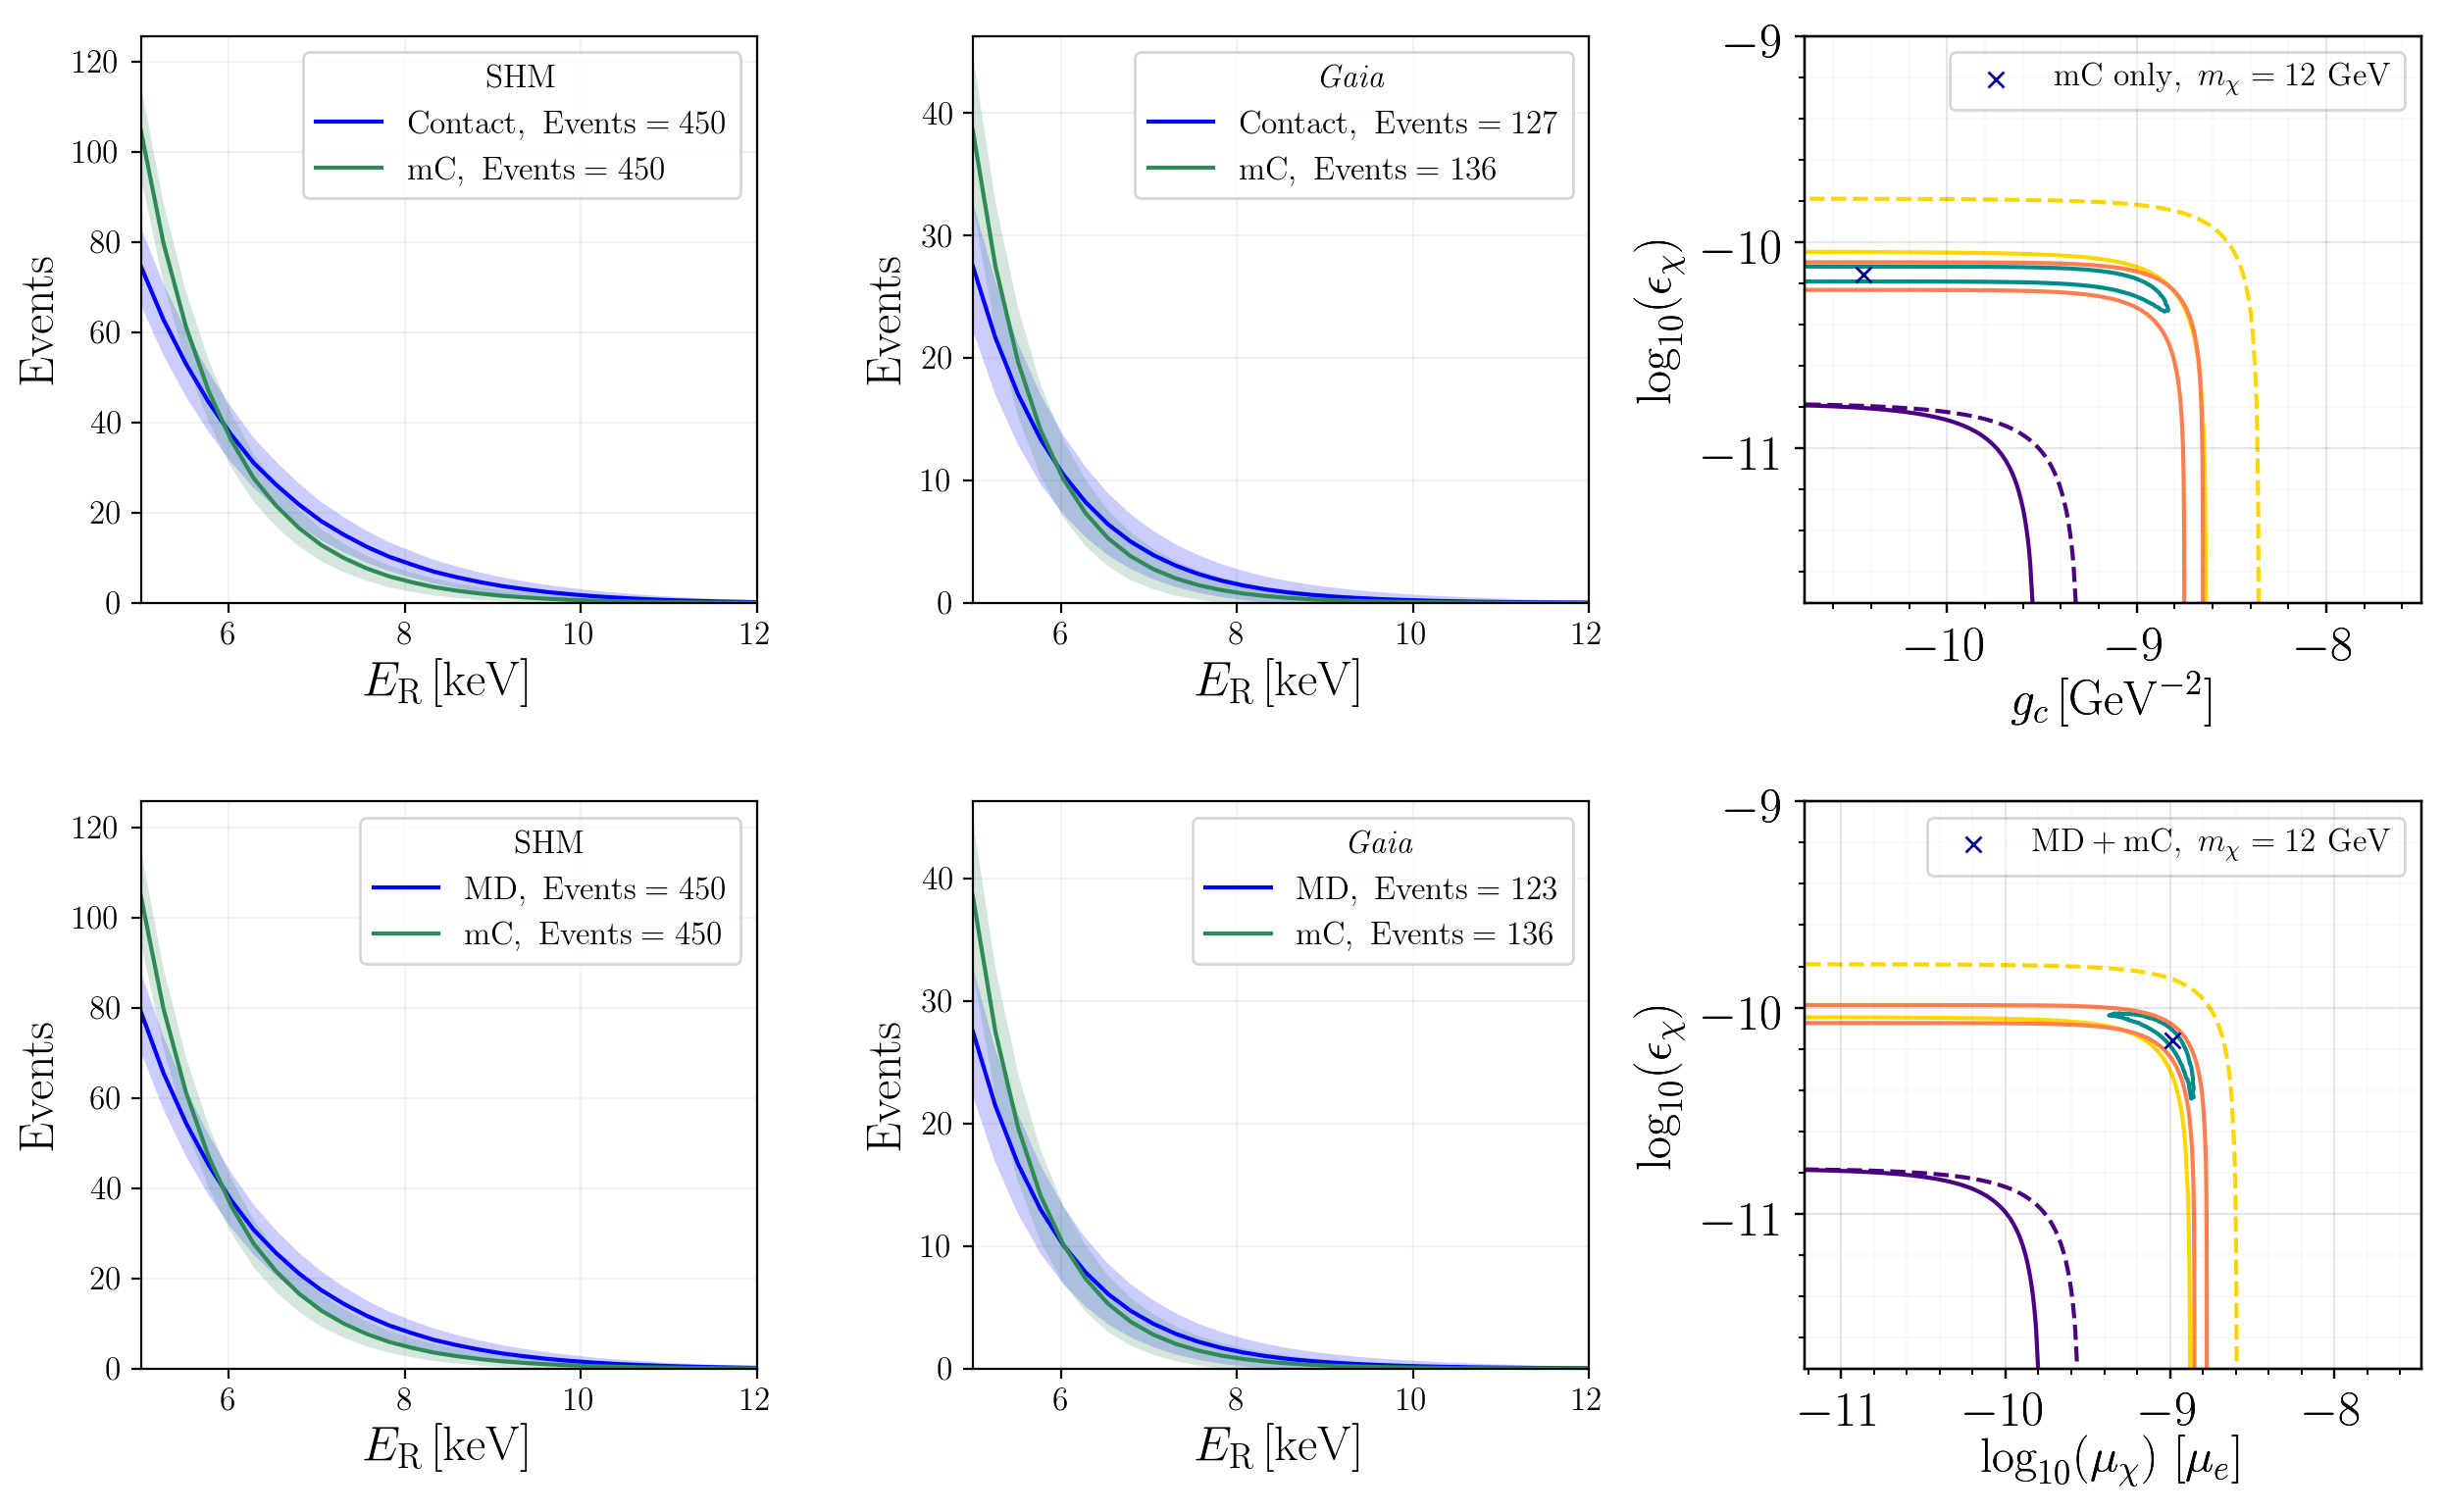

In [344]:
model_text = [['Contact', 'mC'], ['MD', 'mC']]
ops_pair_list = [['SS','mQ'], ['mDM_l','mQ']]

plt.rcParams["figure.figsize"] = (15, 4.5*len(ops_pair_list))
fig, ax = plt.subplots( len(ops_pair_list), 3)
fig.subplots_adjust(wspace=0.35, hspace=0.35)


muH_mQ_list = []; SS_mQ_list = []
SS_muH_list = []; SS_ana_list = []
SS_dH_list = []; SS_muL_list= []

if m_point < 29.:
    SS_mQ_list = get_signal_points(L_SS_list, L_mQ_list, [0,0,1])
    muL_mQ_list = get_signal_points(L_mu_l_list, L_mQ_list, [0,1,0]) 
    SS_muH_list = get_signal_points(L_SS_list, L_mu_h_list, [0,0,1])
    muL_muH_list = get_signal_points(L_mu_l_list, L_mu_h_list, [0,1,0])
    SS_mQ_list_spec = get_signal_points(L_SS_list, L_mQ_list, [1,0,1])
    muL_mQ_list_spec = get_signal_points(L_mu_l_list, L_mQ_list, [1,0,1])
    muL_muH_list_spec = get_signal_points(L_mu_l_list, L_mu_h_list, [1,0,1])
    SS_muH_list_spec = get_signal_points(L_SS_list, L_mu_h_list, [1,0,1])
elif m_point < 79.:
    SS_mQ_list = get_signal_points(H_SS_list, H_mQ_list, [0,0,1])
    muL_mQ_list = get_signal_points(H_mu_l_list, H_mQ_list, [0,1,0])
    SS_muH_list = get_signal_points(H_SS_list, H_mu_h_list, [0,0,1])
    muL_muH_list = get_signal_points(H_mu_l_list, H_mu_h_list, [0,1,0])
    SS_mQ_list_spec = get_signal_points(H_SS_list, H_mQ_list, [1,0,1])
    muL_mQ_list_spec = get_signal_points(H_mu_l_list, H_mQ_list, [1,0,1])
    SS_muH_list_spec = get_signal_points(H_SS_list, H_mu_h_list, [1,0,1])
    muL_muH_list_spec = get_signal_points(H_mu_l_list, H_mu_h_list, [1,0,1])
else:
    SS_mQ_list = get_signal_points(HH_SS_list, HH_mQ_list, [0,0,1])
    muL_mQ_list = get_signal_points(HH_mu_l_list, HH_mQ_list, [0,1,0])
    SS_mQ_list_spec = get_signal_points(HH_SS_list, HH_mQ_list, [1,0,1])
    muL_mQ_list_spec = get_signal_points(HH_mu_l_list, HH_mQ_list, [1,0,1])

cc_plot_list = [SS_mQ_list, muL_mQ_list]
spectrum_plot_list = [SS_mQ_list_spec, muL_mQ_list_spec]

operator_pair_no_table = [[0,1], [3,1]]

xaxsec_list = []
yaxsec_list = []
    
for i_op, opers in enumerate(ops_pair_list):
    cc_plot = cc_plot_list[i_op]
    model_name = model_text[i_op]
    
    row_indx = i_op; col_indx = 2
    low_sigma_0, high_sigma_0 = operators.get_xsec_lim(opers[0])
    low_sigma_1, high_sigma_1 = operators.get_xsec_lim(opers[1])
    if opers[0] == 'SS':
        low_sigma_0 = low_sigma_0-0.5
    if opers[1] == 'SS':
        low_sigma_1 = low_sigma_1-0.5
    if opers[0] == 'mDM_l':
        low_sigma_0 = low_sigma_0+0.5
    if opers[1] == 'mDM_l':
        low_sigma_1 = low_sigma_1+0.5
        
    if m_point < 30.:
        ax[row_indx, col_indx].set_ylim(low_sigma_1+0.75, high_sigma_1-0.5)
        ax[row_indx, col_indx].set_xlim(low_sigma_0+0.75, high_sigma_0-0.5)
    elif m_point < 79.:
        ax[row_indx, col_indx].set_ylim(low_sigma_1, high_sigma_1-1.)
        ax[row_indx, col_indx].set_xlim(low_sigma_0, high_sigma_0-1.)
    else:
        ax[row_indx, col_indx].set_ylim(low_sigma_1-2., high_sigma_1-2.)
        ax[row_indx, col_indx].set_xlim(low_sigma_0-2., high_sigma_0-2.)


    coupling_c0 = coupling_c0_list[i_op]
    coupling_c1 = coupling_c1_list[i_op]
    c0_c1 = cc_list[i_op]
    sh_1 = sh1_list[i_op]

    coupling_NLB_c0 = coupling_NLB_c0_list[i_op]
    coupling_NLB_c1 = coupling_NLB_c1_list[i_op]
    c0_c1_NLB = cc_NLB_list[i_op]
    sh_1_NLB = sh1_NLB_list[i_op]

    #---------------------------------- plotting constraint contours ------------------------------

    SHM_1T_contour = model_SHM_plot_list[i_op]; SHM_Da_contour = model_SHM_Da_plot_list[i_op]
    NLB_1T_contour = model_NLB_plot_list[i_op]; NLB_Da_contour = model_NLB_Da_plot_list[i_op]
    
    ax[row_indx, col_indx].plot(np.log10(NLB_1T_contour[0]), np.log10(NLB_1T_contour[1]), linestyle=Gaia_excl_style, color=excl_1T_color, zorder=0.1)
    ax[row_indx, col_indx].plot(np.log10(NLB_Da_contour[0]), np.log10(NLB_Da_contour[1]), linestyle=Gaia_excl_style, color=excl_Da_color, zorder=0.1)
    ax[row_indx, col_indx].plot(np.log10(SHM_1T_contour[0]), np.log10(SHM_1T_contour[1]), linestyle=SHM_excl_style, color=excl_1T_color, zorder=0.1)
    ax[row_indx, col_indx].plot(np.log10(SHM_Da_contour[0]), np.log10(SHM_Da_contour[1]), linestyle=SHM_excl_style, color=excl_Da_color, zorder=0.1)
    
    #------------------------------------ scanning all contours ------------------------------------
    # commented section can generate fishnet plots
    """
    b = sh_1.get_benchmarks2(sigma=1.5152)
    a = 0
    for i in tqdm(b, desc='contours SHM'):
        plot_ellipse(ax[row_indx, col_indx], sh_1, coupling_c0, coupling_c1, c0_c1, 'SHM', i)
        a +=1

    b = sh_1_NLB.get_benchmarks2(sigma=1.5152)
    a = 0
    for i in tqdm(b, desc='contours NLB'):
        plot_ellipse(ax[row_indx, col_indx], sh_1_NLB, coupling_NLB_c0, coupling_NLB_c1, c0_c1_NLB, 'NLB', i)
        a +=1
    """
    #-----------------------------------------------------------------------------------------------

    if i_op == 0:
        legend_label = r'${\rm %s \ only} ,\ m_\chi = %d {\rm\ GeV}$' % (model_name[1], m_point)
    elif row_indx == 1:
        legend_label = r'${\rm %s} + {\rm %s} ,\ m_\chi = %d {\rm\ GeV}$' % (model_name[0], model_name[1], m_point)
    
    for i_cc, cc in enumerate(cc_plot):
        ax[row_indx, col_indx].plot(cc[0], cc[1], marker='x', color='darkblue', linestyle = 'None', label=legend_label)
        plot_ellipse(ax[row_indx, col_indx], sh_1, coupling_c0, coupling_c1, cc, 'SHM')
        plot_ellipse(ax[row_indx, col_indx], sh_1_NLB, coupling_NLB_c0, coupling_NLB_c1, cc, 'NLB')

    xaxsec, yaxsec = format_fig(ax[row_indx, col_indx], opers[0], opers[1], \
                                r'$g_c\, [{\rm GeV}^{-2}]$', r'$g_c\, [{\rm GeV}^{-2}]$', log_log_in = True, log_log_out = True)
    xaxsec_list.append(xaxsec); yaxsec_list.append(yaxsec)
    
    ax[row_indx, 2].legend()
    
    #-----------------------------------------------------------------------------------------------
    
    sp_acceptance = False;
    if sp_acceptance:
        h_acc = 1.
    else:
        h_acc = 0.5
    for j_coup, coups in enumerate(spectrum_plot_list[i_op]):
        opers_shm = h_acc*expos*dER*(dRT_dER_Model(ER_grid, m_point, 10**(coups[0]), opers[0], experiment=the_experiment, acceptance=sp_acceptance, v_funct = 'SHM')  \
                    + dRT_dER_Model(ER_grid, m_point, 10**(coups[1]), opers[1], experiment=the_experiment, acceptance=sp_acceptance, v_funct = 'SHM') )
        opers_gaia = h_acc*expos*dER*(dRT_dER_Model(ER_grid, m_point, 10**(coups[0]), opers[0], experiment=the_experiment, acceptance=sp_acceptance, v_funct = 'NLB_full') \
                    + dRT_dER_Model(ER_grid, m_point, 10**(coups[1]), opers[1], experiment=the_experiment, acceptance=sp_acceptance, v_funct = 'NLB_full'))
        events_SHM = np.sum(opers_shm)
        events_Gaia = np.sum(opers_gaia)

        if j_coup == 0:
            label_shm = r'$\mathrm{%s ,\ Events } = %i $' % (model_name[0], int(events_SHM) )
            label_gaia = r'$\mathrm{%s ,\ Events } = %i $' % (model_name[0], int(events_Gaia))
        elif j_coup == 1:
            label_shm = r'$\mathrm{%s ,\ Events }= %i$' % (model_name[1], int(events_SHM))
            label_gaia = r'$\mathrm{%s ,\ Events }= %i$' % (model_name[1], int(events_Gaia))
        elif j_coup == 2:
            label_shm = r'$\mathrm{%s + %s ,\ Events }= %i $' % (model_name[0], model_name[1], int(events_SHM))
            label_gaia = r'$\mathrm{%s + %s ,\ Events }= %i $' % (model_name[0], model_name[1], int(events_Gaia))
        
        
        SHM_fig = ax[i_op, 0].plot(ER_grid, opers_shm, color=colorings[j_coup], label=label_shm)
        Gaia_fig = ax[i_op, 1].plot(ER_grid, opers_gaia, color=colorings[j_coup], label=label_gaia)

        
        y_shm_p = (opers_shm + np.sqrt(opers_shm))
        y_shm_n = (opers_shm - np.sqrt(opers_shm))
        y_gaia_p = (opers_gaia + np.sqrt(opers_gaia))
        y_gaia_n = (opers_gaia - np.sqrt(opers_gaia))
        ax[row_indx, 0].fill_between(ER_grid, y_shm_p, y_shm_n, where=(y_shm_n <= y_shm_p), facecolor=colorings[j_coup], interpolate=True, alpha=0.2)
        ax[row_indx, 1].fill_between(ER_grid, y_gaia_p, y_gaia_n, where=(y_gaia_n <= y_gaia_p), facecolor=colorings[j_coup], interpolate=True, alpha=0.2)
    
    ax[row_indx, 0].legend(title=r'$\mathrm{SHM}$'); ax[row_indx, 1].legend(title=r'${\it Gaia}$')
    if m_point < 30.:
        ax[row_indx, 0].set_xlim(5,12); ax[row_indx, 1].set_xlim(5,12)
    else:
        ax[row_indx, 0].set_xlim(5,max(ER_grid)); ax[row_indx, 1].set_xlim(5,max(ER_grid))
    ax[row_indx, 0].set_xlabel(r'$E_{\rm R}\, [{\rm keV}]$', fontsize=18); ax[row_indx, 1].set_xlabel(r'$E_{\rm R}\, [{\rm keV}]$', fontsize=18)
    ax[row_indx, 0].set_ylabel(r'${\rm Events}$', fontsize=18); ax[i_op, 0].set_ylim( (0, 1.2*max(opers_shm)) )
    ax[row_indx, 1].set_ylabel(r'${\rm Events}$', fontsize=18); ax[i_op, 1].set_ylim( (0, 1.2*max( opers_gaia)) )
    ax[row_indx, 0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    ax[row_indx, 1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    ax[row_indx, 0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    ax[row_indx, 1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    

fig.savefig('model_model_sig_L.pdf', bbox_inches = 'tight')

plt.show()

# $\eta_{\rm sub}$-DM parameters signals

In this section, we follow the same logic as the one before. However, this time we constrain the signal in the plane of dark matter coupling/mass and *astrophysics*. We use the DM substructure fraction ($\eta_{\rm sub}$) as the astrophysical parameter to be constrained.

Same as before, we first generate the Euclideanized signals in the two spaces.

In [490]:
ops_list = ['SS', 'mDM_h', 'mQ','eDM_l']

ER_grid = np.linspace(5.,40.,80)
B_null = np.ones_like(ER_grid)*1e-30
B_bkg = bkg_ER(ER_grid)
exposure = np.ones_like(ER_grid)*exposure_func('Xenon_nT')
SF = sf.Swordfish([B_bkg + B_null], E=exposure)

fix_mass = 12.; c_fix_list = [-8.5,-3.4,-9.9,-9.1]

low_mass = 0.5  ;  high_mass = 1.5
sigma_lim_list = [[-9.25,-8.0], [-4.25,-3.0], [-11.0,-9.5], [-10.,-8.75]]

etalist = np.linspace(0., 1., 200)
masslist = np.linspace(low_mass, high_mass, 200)

coupling_list = []; eta_list = []; ES_list = []
mass_list = []; eta_m_list = []; ES_m_list = []
ce_list = []; ce_m_list = []; sh_list = []; sh_m_list = []

for i_op, opers in enumerate(ops_list):
    sigma_lim = sigma_lim_list[i_op]
    low_sigma = sigma_lim[0]  ; high_sigma = sigma_lim[1]
    couplist = np.linspace(low_sigma, high_sigma, 200)

    event_list = np.zeros_like(ER_grid)

    rate_NLB = lambda mDM, coup, eta_sub: (eta_sub*dRT_dER_Model(ER_grid, 10**mDM, 10**coup, opers, experiment='Xenon_nT', acceptance=True, v_funct = 'NLB_subst_full') \
                                    +(1-eta_sub)*dRT_dER_Model(ER_grid, 10**mDM, 10**coup, opers, experiment='Xenon_nT', acceptance=True, v_funct = 'NLB_halo_full') )*dER

    xx, yy = np.meshgrid(ER_grid, ER_grid)
    kk = np.zeros_like(xx)


    c_temp = []; eta_temp = []; ES_temp = [];
    for c in tqdm(couplist, desc=("Euclideanizing coupling "+ str(opers) )):
        for et in etalist:
            c_temp.append(c)
            eta_temp.append(et)
            dRdER = rate_NLB(np.log10(fix_mass), c, et)
            
            if np.sum(dRdER)==0:
                continue
            ES_temp.append(SF.euclideanizedsignal(dRdER))

    coupling_list.append( np.array(c_temp) )
    eta_list.append( np.array(eta_temp) )
    ES_list.append(np.array(ES_temp))
    
    cc = np.zeros([ np.array(eta_temp).shape[0], 1+1])
    cc[:,0] = np.array( c_temp )
    cc[:,1] = np.array( eta_temp )
    
    ce_list.append( cc )
    sh_list.append( sf.SignalHandler( cc, np.array(ES_temp) ) )

    m_temp = []; eta_temp = []; ES_temp = [];
    for m in tqdm(masslist, desc=("Euclideanizing mass "+ str(opers) )):
        for et in etalist:
            m_temp.append(m)
            eta_temp.append(et)
            dRdER = rate_NLB(m, c_fix_list[i_op], et)
            if np.sum(dRdER)==0:
                continue
            ES_temp.append(SF.euclideanizedsignal(dRdER))

    mass_list.append( np.array(m_temp) )
    eta_m_list.append( np.array(eta_temp) )
    ES_m_list.append(np.array(ES_temp))
    
    cc = np.zeros([ np.array(eta_temp).shape[0], 1+1])
    cc[:,0] = np.array( m_temp )
    cc[:,1] = np.array( eta_temp )
    
    ce_m_list.append( cc )
    sh_m_list.append( sf.SignalHandler( cc, np.array(ES_temp) ) )

Euclideanizing mass eDM_l: 100%|██████████| 200/200 [06:17<00:00,  1.89s/it]


### DM model-$\eta_{\rm sub}$ plots

We study the signal contours in two planes, in the DM coupling-substructure fraction plane and the DM mass-substructure fraction plane. Within each plane we hold all other DM model parameters fixed. Because we are studying $\eta_{\rm sub}$, only _Gaia_ astrophysics model is included, as SHM does not assume any DM substructure in its velocity distribution.

The orange contour is the signal contour assuming Niceb et al. median $\eta_{\rm sub} = 0.42$, alongside with some benchmark DM coupling and mass values. We solid and dashed black lines are the XENON1T upper limit and the projected DARWIN upperlimit respectively (for those particular DM benchmark models).

We can see that, as expected, most of the time the ability of DD signal to constrain astrophysics is relatively weak. _i.e._ the signal contours span across the whole range $\eta_{\rm sub} \in [0,1]$.

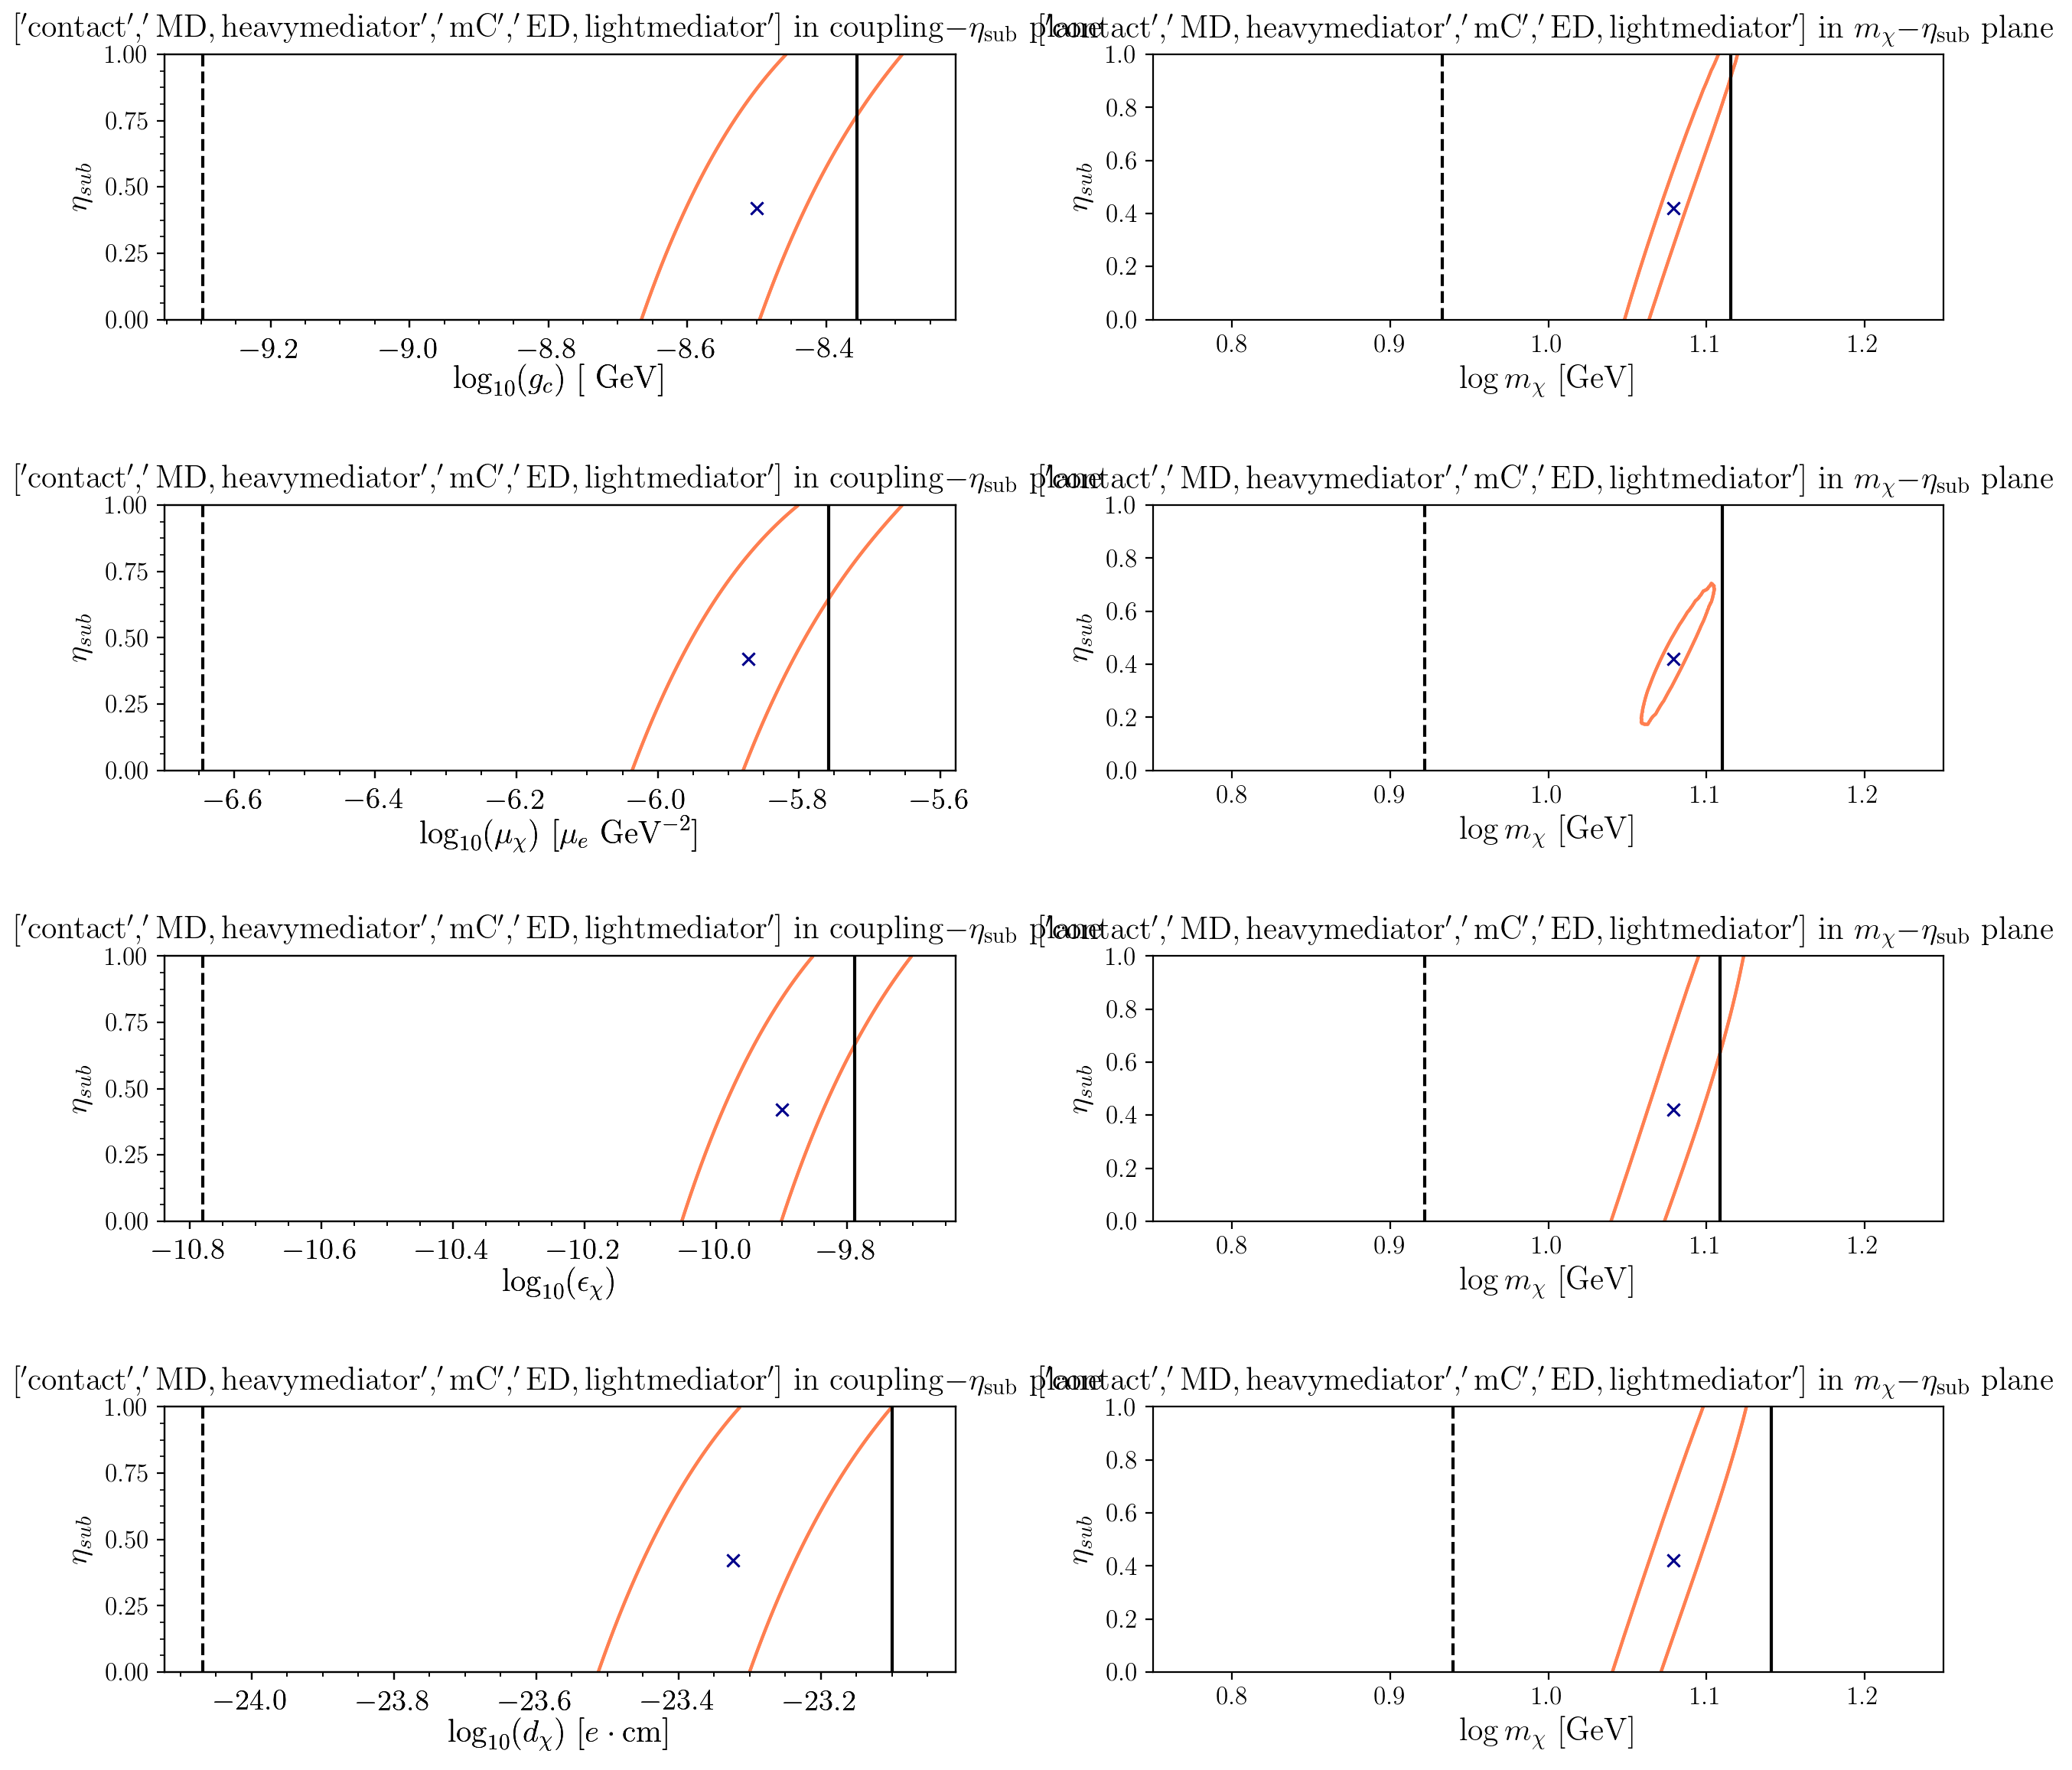

In [492]:
plt.rcParams["figure.figsize"] = (15, 3.5*len(ops_list))
fig, ax = plt.subplots( len(ops_list) , 2)
fig.subplots_adjust(wspace=0.25, hspace=0.7)
plt.rcParams["figure.dpi"] = 100

model_name = [r'contact', r'MD, heavy mediator', r'mC', r'ED, light mediator']


eta_bench = 0.42

muH_mQ_list = []; SS_mQ_list = []
SS_muH_list = []; SS_ana_list = []
SS_dH_list = []; SS_muL_list= []


xaxsec_list = []
yaxsec_list = []
    
for i_op, opers in enumerate(ops_list):
    cm_plot = [[c_fix_list[i_op] , eta_bench], [np.log10(fix_mass), eta_bench]]
    row_indx = i_op 

    #low_sigma, high_sigma = operators.get_xsec_lim(opers)
    sigma_lim = sigma_lim_list[i_op]
    low_sigma = sigma_lim[0]  ; high_sigma = sigma_lim[1]
    couplist = np.linspace(low_sigma, high_sigma, 200)
    
    couplings = coupling_list[i_op]
    etas = eta_list[i_op]
    ce = ce_list[i_op]
    sh = sh_list[i_op]
    
    masses = mass_list[i_op]
    etas_m = eta_m_list[i_op]
    ce_m = ce_m_list[i_op]
    sh_m = sh_m_list[i_op]
   

    #------------------------------------ scanning all contours ------------------------------------

    fix_c = c_fix_list[i_op]
    
    constraint_fix_m = []
    constraint_fix_c = []
    constraint_fix_m_f = []
    constraint_fix_c_f = []

    NLB_1T_CL_pts, plot_mass = EC_upper_limit(ER_grid, masslist, opers, 'Xenon_1T', 'NLB_full', 0.1)
    NLB_1T_CL_pts = np.log10(NLB_1T_CL_pts);  plot_log_mass = np.log10(plot_mass)
    NLB_1T_CL_f_m = interp1d(plot_log_mass, NLB_1T_CL_pts, bounds_error=False, fill_value='extrapolate')
    NLB_1T_CL_f_g = interp1d(NLB_1T_CL_pts, plot_log_mass, bounds_error=False, fill_value='extrapolate')
    NLB_Da_CL_pts, plot_mass = EC_upper_limit(ER_grid, masslist, opers, 'Xenon_Darwin', 'NLB_full', 0.1)
    NLB_Da_CL_pts = np.log10(NLB_Da_CL_pts);  plot_log_mass = np.log10(plot_mass)
    NLB_Da_CL_f_m = interp1d(plot_log_mass, NLB_Da_CL_pts, bounds_error=False, fill_value='extrapolate')
    NLB_Da_CL_f_g = interp1d(NLB_Da_CL_pts, plot_log_mass, bounds_error=False, fill_value='extrapolate')
    
    log_fixed_mass = np.log10(fix_mass)
    ax[row_indx, 0].plot( [NLB_1T_CL_f_m( log_fixed_mass), NLB_1T_CL_f_m(log_fixed_mass)], [min(etalist), max(etalist)], \
                         color='black', zorder=1000)
    ax[row_indx, 1].plot( [NLB_1T_CL_f_g(fix_c), NLB_1T_CL_f_g(fix_c)], [min(etalist), max(etalist)], \
                         color='black', zorder=1000)
    ax[row_indx, 0].plot( [NLB_Da_CL_f_m( log_fixed_mass ), NLB_Da_CL_f_m( log_fixed_mass )], [min(etalist), max(etalist)], \
                         linestyle="--", color='black', zorder=1000)
    ax[row_indx, 1].plot( [NLB_Da_CL_f_g(fix_c), NLB_Da_CL_f_g(fix_c)], [min(etalist), max(etalist)], \
                         linestyle="--", color='black', zorder=1000)

    #------------------------------------ scanning all contours ------------------------------------
    # commented section can generate fishnet plots
    """
    b = sh.get_benchmarks2(sigma=1.5152)
    a = 0
    for i in tqdm(b, desc='contours SHM'):
        plot_ellipse(ax[row_indx, 0], sh, couplings, etas, ce, 'NLB', i)
        a +=1

    b = sh_m.get_benchmarks2(sigma=1.5152)
    a = 0
    for i in tqdm(b, desc='contours NLB'):
        plot_ellipse(ax[row_indx, 1], sh_m, masses, etas_m, ce_m, 'NLB', i)
        a +=1
    """
    #-----------------------------------------------------------------------------------------------
    
    for i_cm, cm in enumerate(cm_plot):
        ax[row_indx, 0].plot(cm_plot[0][0], cm_plot[0][1], marker='x', color='darkblue')
        ax[row_indx, 1].plot(cm_plot[1][0], cm_plot[1][1], marker='x', color='darkblue')
        plot_ellipse(ax[row_indx, 0], sh, couplings, etas, cm_plot[0], 'NLB')
        plot_ellipse(ax[row_indx, 1], sh_m, masses, etas_m, cm_plot[1], 'NLB')
    
    #-----------------------------------------------------------------------------------------------
    #ax[row_indx, col_indx].set_ylim(-0.2, 0.2)
    #ax[row_indx, 0].set_xlim(0.5,1.5)
    ax[row_indx, 1].set_xlim(0.75,1.25)
    ax[row_indx, 0].set_ylabel(r'$\eta_{sub}$', fontsize=15)
    ax[row_indx, 1].set_ylabel(r'$\eta_{sub}$', fontsize=15)
    ax[row_indx, 1].set_xlabel(r'$\log m_{\chi}\ [{\rm GeV}]$', fontsize=15)
    
    ax[row_indx, 0].set_title(r'${\rm %s \ in\ coupling-}\eta_{\rm sub}\ {\rm plane}$' % model_name, fontsize=15)
    ax[row_indx, 1].set_title(r'${\rm %s \ in\ } m_{\chi}{\rm -}\eta_{\rm sub}\ {\rm plane}$' % model_name, fontsize=15)
    
    xlim_down, xlim_up = ax[row_indx, 0].get_xlim()
    
    xaxsec = ax[row_indx, 0].twiny();
    
    if opers == 'mDM_h':
        xaxsec.set_xlim((  mag_moment(xlim_down, True, True), mag_moment(xlim_up, True, True) ))
        xaxsec.set_xlabel(r'$\log_{10}(\mu_\chi)\ [\mu_e{\rm\ GeV}^{-2}]$', fontsize=15);
    elif opers == 'eDM_l':
        xaxsec.set_xlim( (elc_moment( xlim_down, True, True), elc_moment(xlim_up, True, True) ))
        xaxsec.set_xlabel(r'$\log_{10}(d_\chi)\ [e\cdot{\rm cm}]$', fontsize=15);
    elif opers == 'mQ':
        xaxsec.set_xlim( (xlim_down, xlim_up) )
        xaxsec.set_xlabel(r'$\log_{10}(\epsilon_\chi)$', fontsize=15)
    elif opers == 'SS':
        xaxsec.set_xlim( (xlim_down, xlim_up) )
        xaxsec.set_xlabel(r'$\log_{10}(g_c)\ [{\rm \ GeV}]$', fontsize=15)

        
    xaxsec.minorticks_on();
    xaxsec.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(xaxsec.get_yticklabels()[0], visible=False)
    ax[row_indx, 0].xaxis = xaxsec.xaxis
    xaxsec.xaxis.set_label_position('bottom'); xaxsec.xaxis.set_ticks_position('bottom')

plt.show()

# Mediator mass signals

Another set of constraints of interest is the along the mediator mass and DM mass ($m_{\chi}\text{-}m_{\rm med}$) plane. We basically follow the same logic flow of the previous sections.

First of all, we will need to define a new rate fuction since we are not just considering the case of light or heavy propagators.

> ** dRT_dER_mediator(ER, mDM, coup, med_mass, med, experiment, v_funct, acceptance) **
>
> ** dRT_dER_Model_mediator(ER, mDM, coup, med_mass, med, experiment, v_funct, acceptance) ** 

These are the same $\frac{\mathrm{d}R}{\mathrm{d}E_R}$ functions except with an extra *med_mass* argument, which accounts for the propagator factor

$$ \Big(\frac{1}{m_{\rm med}^2 + q^2}\Big)^2. $$

We then find the signal contour in the $m_{\chi}\text{-}m_{\rm med}$ plane.

In [89]:
m_N = 0.938

def dRT_dER_mediator(ER, mDM, coup, med_mass, med, experiment, v_funct, acceptance=True):
    #ER and masses in GeV; as a default couplings are set to 1 in appropriate powers of GeV

    rhoDM= 0.3  #local DM density in GeV/cm^3

    if (experiment.split('_')[0] == 'CDMS'):
        target= '72Ge'
    elif (experiment.split('_')[0] == 'Xenon'):
        target= '131Xe'
    elif (experiment.split('_')[0] == 'Darkside'):
        target= '40Ar'
    
    A = operators.A[target]

    ER_GeV = ER*keVtoGeV
    mT, muT= operators.mass_func(mDM, target)
    N_T= 6.05771E8/A #number of scattering centers per 1 kg of target
    v_min= velDM_min(ER_GeV, mT, muT)
    norm_fac = N_T*(mT/(2*np.pi))*pow(coup, 2)*(rhoDM/mDM)*pow((med_mass**2 + 2*A*m_N*ER_GeV), -2)
    
    if acceptance == True: 
        accept_f = accept_func(ER, experiment)
    else:
        accept_f = 1.
        
    op_num_div = int(len(med[1:])/2)+1
    op_num_a = int(med[1:op_num_div])
    op_num_b = int(med[op_num_div:])
    
    #nuc_form_fac = F_funct(op_num_a, op_num_b, ER, v_min, mu_T=muT, nu=target, v_funct=v_funct)#*invVelToUnitless
    nuc_form_fac =  operators.F_funct(op_num_a, op_num_b, ER, v_min, mu_T=muT, med=med[0], nu=target, v_funct=v_funct)
    return norm_fac*nuc_form_fac*accept_f



def dRT_dER_Model_mediator(ER, mDM, coup, med_mass, med, experiment, v_funct, acceptance=True):
    #ER and masses in GeV; as a default couplings are set to 1 in appropriate powers of GeV

    rhoDM= 0.3  #local DM density in GeV/cm^3

    if (experiment.split('_')[0] == 'CDMS'):
        target= '72Ge'
    elif (experiment.split('_')[0] == 'Xenon'):
        target= '131Xe'
    elif (experiment.split('_')[0] == 'Darkside'):
        target= '40Ar'
    
    A = operators.A[target]

    ER_GeV = ER*keVtoGeV
    mT, muT= operators.mass_func(mDM, target)
    N_T= 6.05771E8/A #number of scattering centers per 1 kg of target
    v_min= velDM_min(ER_GeV, mT, muT)
    norm_fac = N_T*(mT/(2*np.pi))*pow(coup, 2)*(rhoDM/mDM)*pow((med_mass**2 + 2*A*m_N*ER_GeV), -2)
    
    if acceptance == True: 
        accept_f = accept_func(ER, experiment)
    else:
        accept_f = 1.

    #nuc_form_fac =  Model_funct(ER, v_min, mDM, mu_T=muT, med=med, nu=target, v_funct=v_funct)
    nuc_form_fac =  operators.Model_funct(ER, v_min, mDM, mu_T=muT, med=med, nu=target, v_funct=v_funct)
    return norm_fac*nuc_form_fac*accept_f

Generate the DM mass-mediator mass contours.

In [173]:
ops_list = [['h11', -11.78], ['h11', -12.089], ['h1111', -10.14], ['h1111',-10.45]]

ER_grid = np.linspace(5.,40.,80)
dER = ER_grid[1] - ER_grid[0]

event_list = np.zeros_like(ER_grid)
mlist = np.linspace(0.8, 2.5, 100)
medlist = np.linspace(-3., -1., 100)

m_med_list = [] ; mass_list = []
m_med_NLB_list = [] ; mass_NLB_list = []
mm_list = []; mm_NLB_list = []
sh_list = []; sh_NLB_list = []

for i_op, opers_str in enumerate(ops_list):
    
    opers = opers_str[0]; coupling_pt = opers_str[1]
    
    rate = lambda m_med, mDM, coup: dRT_dER_mediator(ER_grid, mDM, coup, m_med, opers, experiment='Xenon_nT', acceptance=True, v_funct = 'SHM')
    rate_NLB = lambda m_med, mDM, coup, eta_sub: eta_sub*dRT_dER_mediator(ER_grid, mDM, coup, m_med, opers, experiment='Xenon_nT', acceptance=True, v_funct = 'NLB_subst_full') \
                                    +(1-eta_sub)*dRT_dER_mediator(ER_grid, mDM, coup, m_med, opers, experiment='Xenon_nT', acceptance=True, v_funct = 'NLB_halo_full')
    if (opers[0] != 'h') and (opers[0] != 'l'):
        rate = lambda m_med, mDM, coup: dRT_dER_Model_mediator(ER_grid, mDM, coup, m_med, opers, experiment='Xenon_nT', acceptance=True, v_funct = 'SHM')
        rate_NLB = lambda m_med, mDM, coup, eta_sub: eta_sub*dRT_dER_Model_mediator(ER_grid, mDM, coup, m_med, opers, experiment='Xenon_nT', acceptance=True, v_funct = 'NLB_subst_full') \
                                    +(1-eta_sub)*dRT_dER_Model_mediator(ER_grid, mDM, coup, m_med, opers, experiment='Xenon_nT', acceptance=True, v_funct = 'NLB_halo_full')

    signal = lambda med_m, m, c: np.abs(rate(10**med_m, 10**m, 10**c)*dER)
    signal_NLB = lambda med_m, m, c: np.abs(rate_NLB(10**med_m, 10**m, 10**c, 0.42)*dER)

    exposure = np.ones_like(ER_grid)*exposure_func('Xenon_Darwin')

    B_null = np.ones_like(ER_grid)*1e-30
    B_bkg = bkg_ER(ER_grid)
    SF = sf.Swordfish([B_bkg + B_null], E=exposure)


    m_med_temp = []; mass_temp = []; ES_temp = [];
    for m in tqdm(mlist, desc=("Euclideanizing SHM " + opers) ):
        for j, medm in enumerate(medlist):
            m_med_temp.append(medm)
            mass_temp.append(m)
            dRdER = signal(medm, m, coupling_pt)
            if np.sum(dRdER)==0:
                continue
            ES_temp.append(SF.euclideanizedsignal(dRdER))

    m_med_list.append( np.array(m_med_temp) )
    mass_list.append( np.array(mass_temp) )

    mm = np.zeros([ np.array(m_med_temp).shape[0], 1+1])
    mm[:,0] = np.array( mass_temp )
    mm[:,1] = np.array( m_med_temp )
    
    mm_list.append( mm )
    sh_list.append( sf.SignalHandler( mm, np.array(ES_temp) ) )
    
    m_med_temp = []; mass_temp = []; ES_temp = [];
    for m in tqdm(mlist, desc=("Euclideanizing Gaia " + opers) ):
        for j, medm in enumerate(medlist):
            m_med_temp.append(medm)
            mass_temp.append(m)
            dRdER = signal_NLB(medm, m, coupling_pt)
            if np.sum(dRdER)==0:
                continue
            ES_temp.append(SF.euclideanizedsignal(dRdER))

    m_med_NLB_list.append( np.array(m_med_temp) )
    mass_NLB_list.append( np.array(mass_temp) )

    mm = np.zeros([np.array(m_med_temp).shape[0], 1+1])
    mm[:,0] = np.array( mass_temp )
    mm[:,1] = np.array( m_med_temp )

    mm_NLB_list.append( mm )
    sh_NLB_list.append( sf.SignalHandler(mm, np.array(ES_temp) ) )

Euclideanizing Gaia h1111: 100%|██████████| 100/100 [02:21<00:00,  1.42s/it]


### $m_\chi$-$m_{\rm med}$ signal plots

We examine the DM-mediator mass signals for two NREFT operators: $\mathcal{O}_{1}, \ \mathcal{O}_{11}$. They are also understood to be the operators for contact interaction and the SI part of the pseudoscalar interactions.

We show three benchmark points at each model and fixed coupling strength. They correspond to light, medium-mass and heavy mediators, compared to the nuclear recoil momentum exchange scale (q). Once again, the orange contour corresponds to _Gaia_ signal and cyan to SHM.

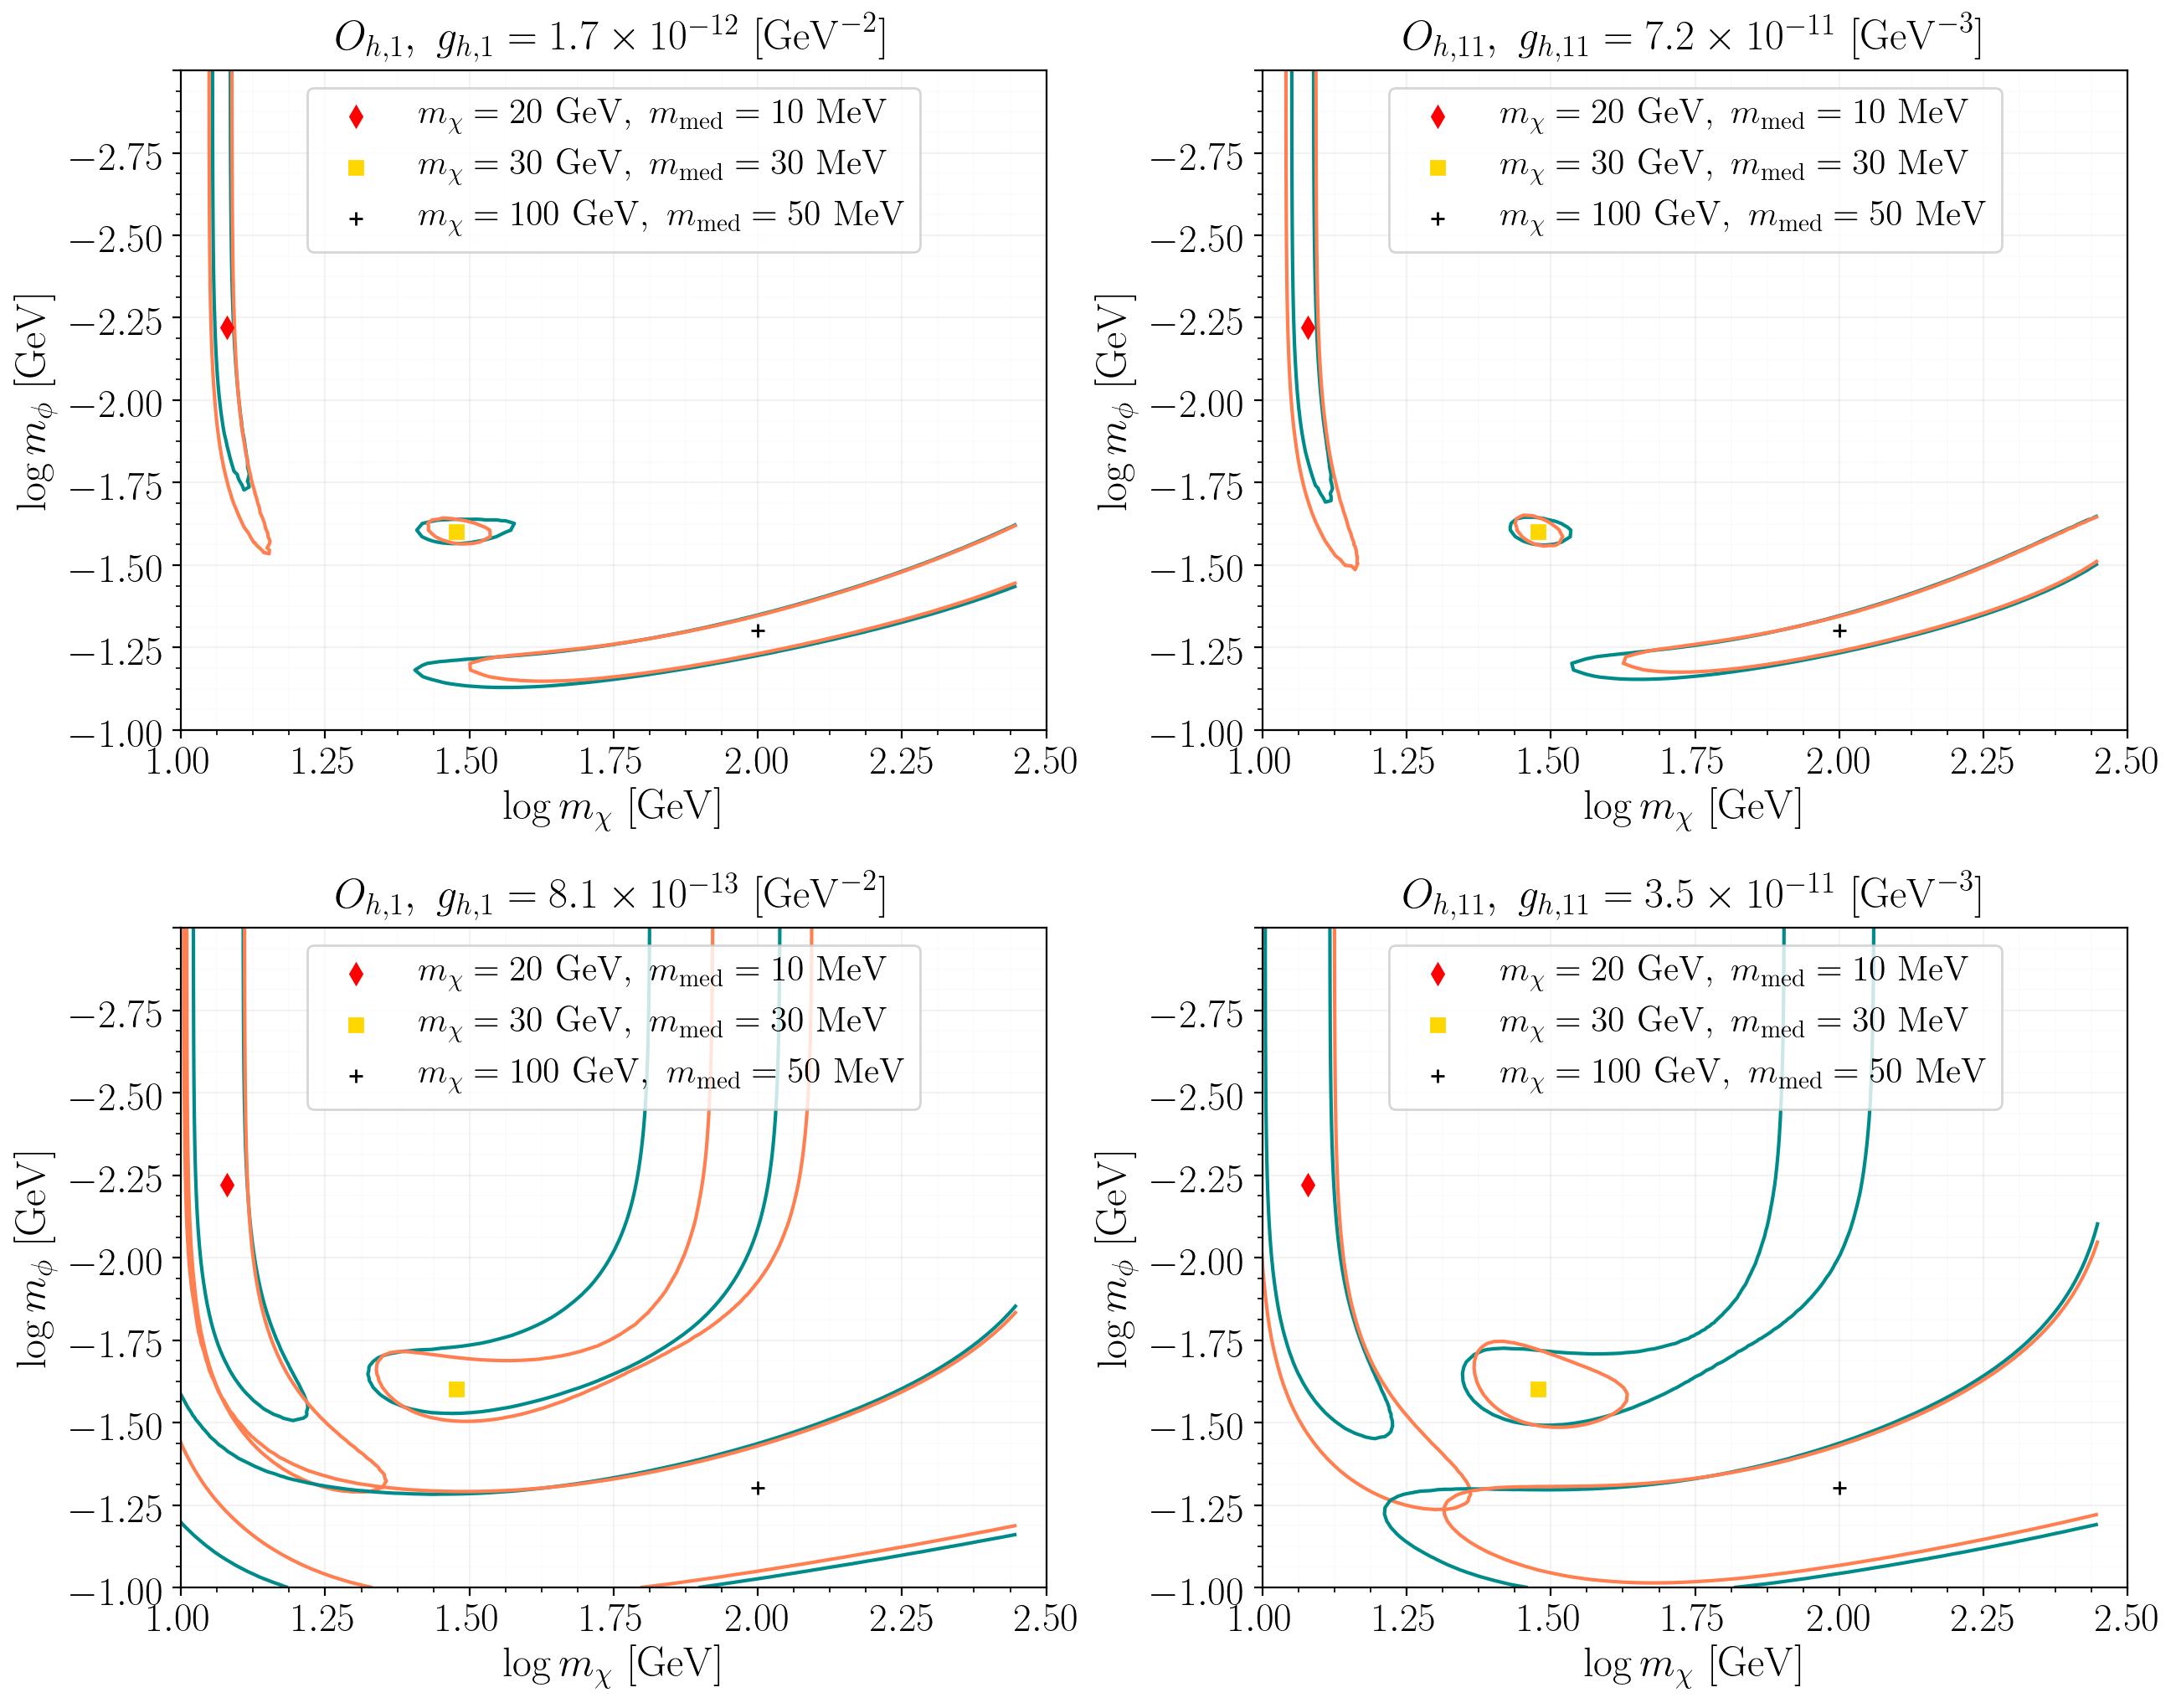

In [177]:
plt.rcParams["figure.figsize"] = (15, 3.*len(ops_list))
fig, ax = plt.subplots( int(np.ceil(len(ops_list)/2)) , 2)
fig.subplots_adjust(wspace=0.25, hspace=0.3)
plt.rcParams["figure.dpi"] = 100

mm_a_list = [[12, 6e-3],[30, 2.5e-2],[100, 5e-2]]; 
mm_b_list = [[15, 6e-3],[35, 2.5e-2],[100, 5e-2]]

point_list = [['d','red'],['s','gold'],['+','black']]
oper_label = [['1',r'[{\rm GeV}^{-2}]'],['1',r'[{\rm GeV}^{-2}]'],\
              ['11',r'[{\rm GeV}^{-3}]'],['11',r'[{\rm GeV}^{-3}]']]

mm_plot_list = np.log10([mm_a_list, mm_a_list, \
                    mm_a_list, mm_a_list,
                    mm_b_list, mm_b_list])

xaxsec_list = []
yaxsec_list = []
    
for i_op, opers in enumerate(ops_list):
    row_indx = np.divide(i_op, 2); col_indx = np.mod(i_op, 2)

    mm_s = mm_list[i_op]
    med_m = m_med_list[i_op]
    dm_m = mass_list[i_op]
    sh = sh_list[i_op]
    
    mm_nlb_s = mm_NLB_list[i_op]
    med_m_nlb = m_med_NLB_list[i_op]
    dm_m_nlb = mass_NLB_list[i_op]
    sh_nlb = sh_NLB_list[i_op]
    
    #-----------------------------------------------------------------------------------------------
    # commented section can generate fishnet plots
    """
    b = sh.get_benchmarks2(sigma=1.5152)
    a = 0
    for i in tqdm(b, desc='contours SHM'):
        plot_ellipse(ax[row_indx, col_indx], sh, dm_m, med_m, mm_s, 'SHM', i)
        a +=1

    b = sh_nlb.get_benchmarks2(sigma=1.5152)
    a = 0
    for i in tqdm(b, desc='contours NLB'):
        plot_ellipse(ax[row_indx, col_indx], sh_nlb, dm_m_nlb, med_m_nlb, mm_nlb_s, 'NLB', i)
        a +=1
        
    """
    #-----------------------------------------------------------------------------------------------
    
    mm_plot = mm_plot_list[i_op]
    
    for i_mm, mm in enumerate(mm_plot):
        point_style = point_list[i_mm]
        dm_mass = np.ceil(10**mm[0]/10.); med_mass = np.ceil(10**mm[1]*1e3/5.)
        point_label = r'$m_\chi = %d {\rm \ GeV}, \ m_{\rm med} = %d {\rm \ MeV}$' % (10*dm_mass, 5*med_mass)
        ax[col_indx, row_indx].plot(mm[0], mm[1], marker=point_style[0], color=point_style[1], label=point_label, linestyle = 'None')
        plot_ellipse(ax[col_indx, row_indx], sh, dm_m, med_m, mm, 'SHM')
        plot_ellipse(ax[col_indx, row_indx], sh_nlb, dm_m_nlb, med_m_nlb, mm, 'NLB')
    
    #-----------------------------------------------------------------------------------------------
    
    ax[col_indx, row_indx].set_xlim(min(mlist)+0.2,max(mlist))
    ax[col_indx, row_indx].set_ylim(max(medlist),min(medlist))
    ax[col_indx, row_indx].set_ylabel(r'$\log m_{\phi}\ [{\rm GeV}]$', fontsize=18)
    ax[col_indx, row_indx].set_xlabel(r'$\log m_{\chi}\ [{\rm GeV}]$', fontsize=18)
    
    ax[col_indx, row_indx].legend(loc='upper center', frameon=True, fontsize=15)
    coup_label = r'%.1f \times 10^{%d}' % (10**(opers[1]-np.floor(opers[1])), np.floor(opers[1]))
    plot_title = r'$O_{h,%s},\ g_{h,%s}=%s \ %s$' % (oper_label[i_op][0], oper_label[i_op][0], coup_label, oper_label[i_op][1])
    ax[col_indx, row_indx].set_title(plot_title, fontsize=18)
    
    ax[col_indx,row_indx].minorticks_on();
    ax[col_indx,row_indx].tick_params(axis='both', which='major', labelsize=17)
    ax[col_indx,row_indx].tick_params(axis='both', which='minor', labelsize=16)
    ax[col_indx,row_indx].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    ax[col_indx,row_indx].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    plt.setp(ax[col_indx,row_indx].get_yticklabels()[0], visible=False)

plt.show()